# Bone Marrow Transplant Children Notebook

### Packages Imports

In [205]:
import pandas as pd
from scipy.io import arff
from scipy import stats
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score,learning_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import resample


# I. Data Preprocessing and Exploratory Data Analysis
In this section, we undertake several preprocessing steps to ensure the data is clean, properly formatted, and ready for analysis. These steps are crucial for accurate machine learning predictions and involve transforming the data format, cleaning, encoding categorical variables, and normalizing numerical values.

## 1. Data Preprocessing

### 1.1. Format Conversion

In [206]:
# Load the ARFF file
path = 'BMT_DATA/bone-marrow.arff'
data = arff.loadarff(path)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data[0])

# Convert byte strings to strings if necessary (common with ARFF files)
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Save the DataFrame to a CSV file
csv_path = 'BMT_DATA/bone-marrow-converted.csv'
df.to_csv(csv_path, index=False)

print("ARFF file has been converted to CSV.")


ARFF file has been converted to CSV.


/var/folders/pt/2gvzzpzs05z5fkc59dq42ft40000gn/T/ipykernel_9865/82846068.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


### 1.2.Previewing Bone Marrow Dataset
Before diving into cleaning and transforming the data, we'll get an initial overview of the dataset as it stands after conversion.

In [207]:
# Display the first few rows of the dataset to understand its structure
print(df.head())

  Recipientgender Stemcellsource   Donorage Donorage35 IIIV Gendermatch  \
0               1              1  22.830137          0    1           0   
1               1              0  23.342466          0    1           0   
2               1              0  26.394521          0    1           0   
3               0              0  39.684932          1    1           0   
4               0              1  33.358904          0    0           0   

  DonorABO RecipientABO RecipientRh ABOmatch  ... extcGvHD CD34kgx10d6  \
0        1            1           1        0  ...        1        7.20   
1       -1           -1           1        0  ...        1        4.50   
2       -1           -1           1        0  ...        1        7.94   
3        1            2           1        1  ...        ?        4.25   
4        1            2           0        1  ...        1       51.85   

    CD3dCD34 CD3dkgx10d8 Rbodymass ANCrecovery PLTrecovery  \
0   1.338760        5.38      35.0        

  The first few rows of the bone marrow dataset provide an overview of patient characteristics and medical details. Key features include Recipientgender, Stemcellsource, Donorage, IIIV, Gendermatch, DonorABO, RecipientABO, and survival_status. The dataset contains both numerical and categorical data, with some missing values represented by '?'. The initial data exploration shows a mix of demographic information and clinical measurements,we can notice that the features are divided into two sections:"Pre-transplant Features" like:**CD3dCD34** , **Rbodymas**, and "Post-Transplant Features" like **time_to_aGvHD_III_IV**,**survival_time** , this requires a detailed analysis on how to choose features in the upcoming sections.

### 1.3.Summary Statistics

In [208]:
# Display summary statistics to get an idea of the data's distribution
print(df.describe())

         Donorage  Recipientage  CD34kgx10d6    CD3dCD34  CD3dkgx10d8  \
count  187.000000    187.000000   187.000000  182.000000   182.000000   
mean    33.472068      9.931551    11.891781    5.385096     4.745714   
std      8.271826      5.305639     9.914386    9.598716     3.859128   
min     18.646575      0.600000     0.790000    0.204132     0.040000   
25%     27.039726      5.050000     5.350000    1.786683     1.687500   
50%     33.550685      9.600000     9.720000    2.734462     4.325000   
75%     40.117809     14.050000    15.415000    5.823565     6.785000   
max     55.553425     20.200000    57.780000   99.560970    20.020000   

        Rbodymass     ANCrecovery     PLTrecovery  time_to_aGvHD_III_IV  \
count  185.000000      187.000000      187.000000            187.000000   
mean    35.801081    26752.866310    90937.919786         775408.042781   
std     19.650922   161747.200525   288242.407688         418425.252689   
min      6.000000        9.000000        9

The summary statistics of the bone marrow dataset provide insights into the distribution of various features. The Donorage ranges from approximately 18 to 56 years, while Recipientage ranges from less than 1 year to 20 years. The CD34kgx10d6 and CD3dkgx10d8 values indicate variability in cell measurements, with CD34kgx10d6 ranging from 0.79 to 57.78 and CD3dkgx10d8 from 0.04 to 20.02. The Rbodymass shows a wide range, from 6.0 to 103.4. Notably, the time_to_aGvHD_III_IV feature has a large number of maximum values, indicating potential censoring or a significant number of patients not experiencing this event. The survival_time varies from 6 to 3364 days, with a mean of 939 days, while the survival_status is roughly balanced, with 45.5% of patients having survived.

### 1.4. Data Cleaning

In this section, we begin our data cleaning process by identifying any missing or incomplete data points. Understanding where and why data may be missing is crucial for informed imputation and ensuring the robustness of subsequent analyses

#### 1.4.1 Identifying Non-Numeric Columns

We must ensure that the DataFrame only contains numeric data. We'll check for non-numeric columns and decide how to handle them – either by encoding them appropriately

In [210]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Recipientgender', 'Stemcellsource', 'Donorage35', 'IIIV',
       'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch',
       'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Disease', 'Riskgroup',
       'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen',
       'Alel', 'HLAgrI', 'Recipientage10', 'Recipientageint', 'Relapse',
       'aGvHDIIIIV', 'extcGvHD'],
      dtype='object')


##### Check Unique Values of Non-Numeric Columns

In [211]:
# Check the unique values for these non-numeric (integer-encoded) columns
for column in non_numeric_columns:
    print(f"{column}: Unique values: {df[column].unique()}")

Recipientgender: Unique values: ['1' '0']
Stemcellsource: Unique values: ['1' '0']
Donorage35: Unique values: ['0' '1']
IIIV: Unique values: ['1' '0']
Gendermatch: Unique values: ['0' '1']
DonorABO: Unique values: ['1' '-1' '2' '0']
RecipientABO: Unique values: ['1' '-1' '2' '0' '?']
RecipientRh: Unique values: ['1' '0' '?']
ABOmatch: Unique values: ['0' '1' '?']
CMVstatus: Unique values: ['3' '0' '2' '1' '?']
DonorCMV: Unique values: ['1' '0' '?']
RecipientCMV: Unique values: ['1' '0' '?']
Disease: Unique values: ['ALL' 'AML' 'chronic' 'nonmalignant' 'lymphoma']
Riskgroup: Unique values: ['1' '0']
Txpostrelapse: Unique values: ['0' '1']
Diseasegroup: Unique values: ['1' '0']
HLAmatch: Unique values: ['0' '1' '3' '2']
HLAmismatch: Unique values: ['0' '1']
Antigen: Unique values: ['-1' '1' '0' '2' '?']
Alel: Unique values: ['-1' '0' '2' '1' '3' '?']
HLAgrI: Unique values: ['0' '1' '7' '3' '2' '4' '5']
Recipientage10: Unique values: ['0' '1']
Recipientageint: Unique values: ['1' '0' '2']

#### 1.4.2.Handling Missing Data

In [212]:
# We also notice that some columns contain '?', which indicates missing data.
# We need to decide how to handle these. For simplicity, let's treat them as NaN and then impute.
df.replace('?', np.nan, inplace=True)

# Check for missing values after replacing '?' with NaN.
print(df.isnull().sum())

Recipientgender          0
Stemcellsource           0
Donorage                 0
Donorage35               0
IIIV                     0
Gendermatch              0
DonorABO                 0
RecipientABO             1
RecipientRh              2
ABOmatch                 1
CMVstatus               16
DonorCMV                 2
RecipientCMV            14
Disease                  0
Riskgroup                0
Txpostrelapse            0
Diseasegroup             0
HLAmatch                 0
HLAmismatch              0
Antigen                  1
Alel                     1
HLAgrI                   0
Recipientage             0
Recipientage10           0
Recipientageint          0
Relapse                  0
aGvHDIIIIV               0
extcGvHD                31
CD34kgx10d6              0
CD3dCD34                 5
CD3dkgx10d8              5
Rbodymass                2
ANCrecovery              0
PLTrecovery              0
time_to_aGvHD_III_IV     0
survival_time            0
survival_status          0
d

The dataset shows several features with missing values after replacing '?' with NaN. The columns CMVstatus and RecipientCMV have the highest number of missing values, with 16 and 14 missing entries, respectively. Other columns like RecipientRh, DonorCMV, CD3dCD34, and CD3dkgx10d8 have a few missing values ranging from 2 to 5. Additionally, columns such as RecipientABO, ABOmatch, Antigen, and Alel have 1 missing value each. Addressing these missing values is crucial for ensuring the integrity and reliability of the predictive models developed from this dataset. Appropriate imputation techniques need to be applied to handle these missing entries effectively.

##### 1.4.2.1.KNN Imputation/ Dropping Instances for Missing Data

In [213]:
# Prepare the dataset for KNN imputation
imputation_data = df[['CD34kgx10d6', 'CD3dkgx10d8', 'CD3dCD34']]

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
imputed_data = knn_imputer.fit_transform(imputation_data)

# Assign the imputed values back to the original dataset
df[['CD34kgx10d6', 'CD3dkgx10d8', 'CD3dCD34']] = imputed_data# Drop rows with missing 'ABOmatch' values

df.dropna(subset=['ABOmatch','Antigen', 'Alel', 'RecipientRh','CMVstatus','RecipientABO', 'DonorABO'], inplace=True)

# Display the dataset to check the final state
df[['ABOmatch', 'survival_status','RecipientABO', 'DonorABO']].head(10)


,ABOmatch,survival_status,RecipientABO,DonorABO
0,0,0.0,1,1
1,0,1.0,-1,-1
2,0,1.0,-1,-1
3,1,1.0,2,1
4,1,0.0,2,1
7,1,1.0,1,0
8,1,0.0,0,2
9,1,0.0,0,1
10,1,0.0,-1,0
11,0,0.0,1,1


After dropping rows with missing values in ABOmatch, Antigen, Alel, RecipientRh, CMVstatus, RecipientABO, and DonorABO, the dataset reveals a refined view of the relationship between ABOmatch and survival_status. The cleaned data shows that both matched and unmatched ABO pairs exist among survivors and non-survivors. Specifically, there are instances where an ABO match corresponds with survival, suggesting a potential positive influence, while mismatches do not always correlate with non-survival. This indicates the need for further analysis to determine the exact impact of ABO matching on patient outcomes. Negative values in RecipientABO and DonorABO likely represent special cases or specific blood types, adding another layer to the analysis.








##### 1.4.2.2.Filling Missing CMV Status

In [163]:
# Function to fill CMVstatus, DonorCMV, and RecipientCMV based on the given rules
def fill_cmv_status(row):
    # Fill CMVstatus
    if pd.notna(row['CMVstatus']):
        return row['CMVstatus'], row['DonorCMV'], row['RecipientCMV']

    if pd.notna(row['DonorCMV']) and pd.notna(row['RecipientCMV']):
        if row['DonorCMV'] == 0 and row['RecipientCMV'] == 0:
            return 0, row['DonorCMV'], row['RecipientCMV']
        elif row['DonorCMV'] == 1 and row['RecipientCMV'] == 0:
            return 1, row['DonorCMV'], row['RecipientCMV']
        elif row['DonorCMV'] == 0 and row['RecipientCMV'] == 1:
            return 2, row['DonorCMV'], row['RecipientCMV']
        elif row['DonorCMV'] == 1 and row['RecipientCMV'] == 1:
            return 3, row['DonorCMV'], row['RecipientCMV']

    if pd.isna(row['CMVstatus']):
        if row['survival_status'] == 0:
            if pd.isna(row['DonorCMV']):
                donor_cmv = 1 if row['RecipientCMV'] == 1 else 0
                return 1 if row['RecipientCMV'] == 1 else 3, donor_cmv, row['RecipientCMV']
            if pd.isna(row['RecipientCMV']):
                recipient_cmv = 0 if row['DonorCMV'] == 0 else 1
                return 2 if row['DonorCMV'] == 0 else 3, row['DonorCMV'], recipient_cmv
        else:
            if pd.isna(row['DonorCMV']):
                donor_cmv = 0 if row['RecipientCMV'] == 0 else 1
                return 0 if row['RecipientCMV'] == 0 else 2, donor_cmv, row['RecipientCMV']
            if pd.isna(row['RecipientCMV']):
                recipient_cmv = 0 if row['DonorCMV'] == 0 else 1
                return 0 if row['DonorCMV'] == 0 else 1, row['DonorCMV'], recipient_cmv

    return row['CMVstatus'], row['DonorCMV'], row['RecipientCMV']

# Apply the function to fill missing CMVstatus, DonorCMV, and RecipientCMV values
df[['CMVstatus', 'DonorCMV', 'RecipientCMV']] = df.apply(fill_cmv_status, axis=1, result_type='expand')

# Display the first few rows of the modified dataset
display_data = df[['CMVstatus', 'DonorCMV', 'RecipientCMV', 'survival_status']]
display_data.head(10)

,CMVstatus,DonorCMV,RecipientCMV,survival_status
0,3,1,1,0.0
1,0,0,0,1.0
2,2,0,1,1.0
3,1,1,0,1.0
4,0,0,1,0.0
7,1,1,0,1.0
8,2,0,1,0.0
9,2,0,1,0.0
10,1,1,0,0.0
11,0,0,0,0.0


The dataset, now with filled values for CMVstatus, DonorCMV, and RecipientCMV, reveals interesting patterns regarding patient survival. The CMVstatus column categorizes CMV conditions from 0 to 3, reflecting different donor and recipient CMV combinations. Patients with CMVstatus of 3 (both donor and recipient CMV positive) and 1 (donor positive, recipient negative) are present among both survivors and non-survivors. Similarly, a CMVstatus of 0 (both donor and recipient CMV negative) shows varied survival outcomes. These findings suggest that the CMV status of donors and recipients potentially influences patient survival, indicating the need for further analysis to fully understand these relationships.

##### 1.4.2.3.Imputation of Body Mass Based on Recipient Age|

In [164]:
# Calculate mean body mass for each specific age
age_means = df.groupby('Recipientage')['Rbodymass'].mean()

# Function to impute missing values with age-specific means
def impute_bodymass(row):
    if pd.isna(row['Rbodymass']):
        return age_means[row['Recipientage']]
    else:
        return row['Rbodymass']

# Apply the imputation function
df['Rbodymass'] = df.apply(impute_bodymass, axis=1)


# Drop any remaining rows with missing 'Rbodymass' values
df.dropna(subset=['Rbodymass'], inplace=True)


# Display the dataset to check the imputed values
df[['Rbodymass', 'Recipientage']].head(10)



,Rbodymass,Recipientage
0,35.0,9.6
1,20.6,4.0
2,23.4,6.6
3,50.0,18.1
4,9.0,1.3
7,56.0,18.2
8,20.5,7.9
9,16.5,4.7
10,10.5,1.9
11,47.0,13.4


The imputation process for Rbodymass based on Recipientage has successfully filled in missing values with the mean body mass for each specific age group. For example, a recipient aged 9.6 years has an imputed body mass of 35.0, while another aged 18.1 years has a body mass of 50.0. This method ensures that the imputed values are contextually appropriate, reflecting typical body mass values for recipients of similar ages. The dataset now has complete Rbodymass values, improving the quality and reliability of subsequent analyses and model training.

##### 1.4.2.4.Imputation of extcGvHD

In [165]:
# Prepare the dataset for KNN imputation
imputation_data = df[['extcGvHD']]

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
imputed_data = knn_imputer.fit_transform(imputation_data)

# Assign the imputed values back to the original dataset
df['extcGvHD'] = imputed_data

# Verify if there are any remaining missing values
missing_values = df.isnull().sum()

# Display the dataset to check the imputed values
display_data = df[['extcGvHD']]
display_data.head(10)



,extcGvHD
0,1.000000
1,1.000000
2,1.000000
3,0.833333
4,1.000000
7,0.833333
8,1.000000
9,1.000000
10,0.000000
11,0.000000


##### 1.4.2.5.Checking missing values after imputation

In [166]:
# Check for missing values after replacing '?' with NaN.
print(df.isnull().sum())

Recipientgender         0
Stemcellsource          0
Donorage                0
Donorage35              0
IIIV                    0
Gendermatch             0
DonorABO                0
RecipientABO            0
RecipientRh             0
ABOmatch                0
CMVstatus               0
DonorCMV                0
RecipientCMV            0
Disease                 0
Riskgroup               0
Txpostrelapse           0
Diseasegroup            0
HLAmatch                0
HLAmismatch             0
Antigen                 0
Alel                    0
HLAgrI                  0
Recipientage            0
Recipientage10          0
Recipientageint         0
Relapse                 0
aGvHDIIIIV              0
extcGvHD                0
CD34kgx10d6             0
CD3dCD34                0
CD3dkgx10d8             0
Rbodymass               0
ANCrecovery             0
PLTrecovery             0
time_to_aGvHD_III_IV    0
survival_time           0
survival_status         0
dtype: int64


The results show that there are no remaining missing values in any of the columns, indicating that the imputation and data cleaning processes were successful. The dataset is now complete and ready for further analysis and modeling.

#### 1.4.3. Conversion of columns

In [167]:
# List to keep track of columns converted
converted_columns = []

for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:  # Check if the column is float or int
        unique_values = df[column].dropna().unique()  # Get unique values excluding NaN
        # Check if the unique values in the column are only 0.0 and 1.0
        if set(unique_values).issubset({0.0, 1.0}):
            df[column] = df[column].astype(bool)
            converted_columns.append(column)

print(f"Converted columns to boolean: {converted_columns}")


Converted columns to boolean: ['survival_status']


#### 1.4.3. One-hot encoding

In [168]:
# One-hot encode the 'Disease' column
df = pd.get_dummies(df, columns=['Disease'], drop_first=True)

# Display the dataset to check the one-hot encoded 'Disease' column
df.head(10)

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant
0,1,1,22.830137,0,1,0,1,1,1,0,...,35.0,19.0,51.0,32.0,999.0,False,False,False,False,False
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,20.6,16.0,37.0,1000000.0,163.0,True,False,False,False,False
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,23.4,23.0,20.0,1000000.0,435.0,True,False,False,False,False
3,0,0,39.684932,1,1,0,1,2,1,1,...,50.0,23.0,29.0,19.0,53.0,True,True,False,False,False
4,0,1,33.358904,0,0,0,1,2,0,1,...,9.0,14.0,14.0,1000000.0,2043.0,False,False,True,False,False
7,1,0,21.435616,0,1,0,0,1,1,1,...,56.0,22.0,58.0,22.0,45.0,True,False,False,False,True
8,1,1,32.641096,0,0,0,2,0,1,1,...,20.5,15.0,14.0,1000000.0,671.0,False,False,False,False,True
9,1,1,28.783562,0,1,1,1,0,1,1,...,16.5,16.0,17.0,1000000.0,676.0,False,False,False,False,True
10,0,1,29.731507,0,0,0,0,-1,1,1,...,10.5,12.0,13.0,1000000.0,599.0,False,False,True,False,False
11,0,1,36.800000,1,1,0,1,1,1,0,...,47.0,11.0,16.0,1000000.0,2503.0,False,False,True,False,False


#### 1.4.4.Recoding Placeholder Values
Address placeholder values used in place of missing data, such as the 1000000.0 in 'time_to_aGvHD_III_IV'.

In [169]:
# Recode placeholder values to a more appropriate representation
df['time_to_aGvHD_III_IV'] = df['time_to_aGvHD_III_IV'].replace(1000000.0, 0)


#### 1.4.5.Normalizing/Scaling Numerical Variables

To ensure that all features contribute equally to the analysis, we normalize the data. This process involves scaling numerical values to a common scale without distorting differences in the ranges of values.

In [170]:
# Assuming 'df' is your DataFrame after previous cleaning steps.
# Initialize the StandardScaler
scaler = StandardScaler()

# Select only the numeric columns from the dataframe
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Scale these numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display the first few rows of the scaled data to confirm the process
df.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant
0,1,1,-1.299935,0,1,0,1,1,1,0,...,-0.027264,-0.156149,-0.277272,1.565642,0.011433,False,False,False,False,False
1,1,0,-1.236384,0,1,0,-1,-1,1,0,...,-0.778900,-0.156168,-0.277326,-0.409690,-0.969465,True,False,False,False,False
2,1,0,-0.857797,0,1,0,-1,-1,1,0,...,-0.632749,-0.156123,-0.277392,-0.409690,-0.650321,True,False,False,False,False
3,0,0,0.790791,1,1,0,1,2,1,1,...,0.755691,-0.156123,-0.277357,0.763163,-1.098530,True,True,False,False,False
4,0,1,0.006089,0,0,0,1,2,0,1,...,-1.384385,-0.156182,-0.277415,-0.409690,1.236382,False,False,True,False,False


## 2. Exploratory Data Analysis (EDA)

### 2.1.Visualisations of the Impact of numerical predictors on target feature

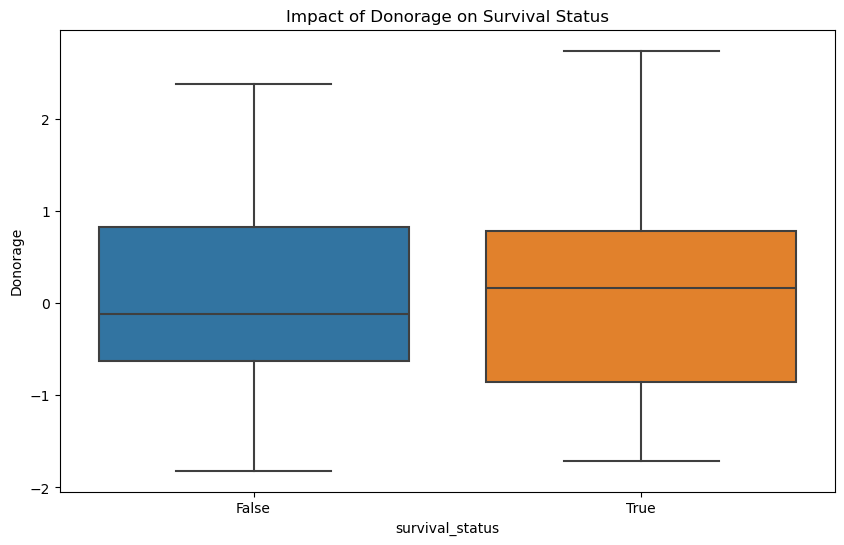

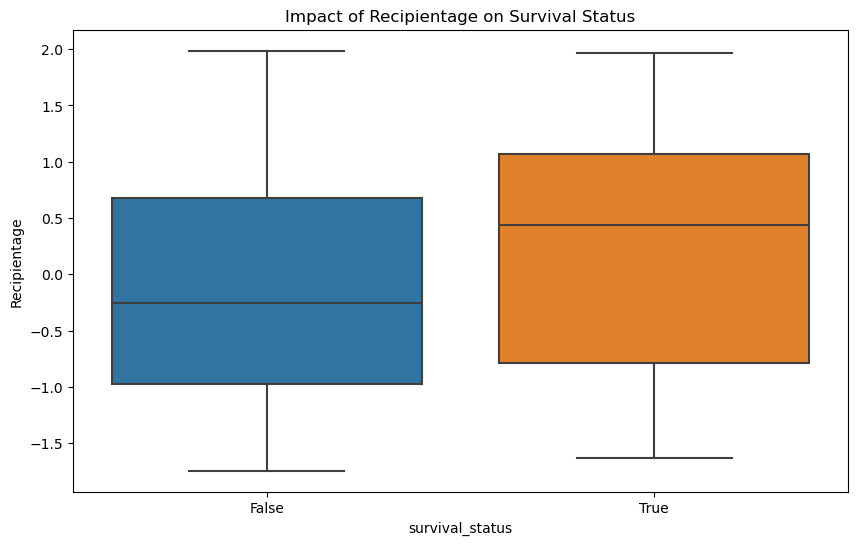

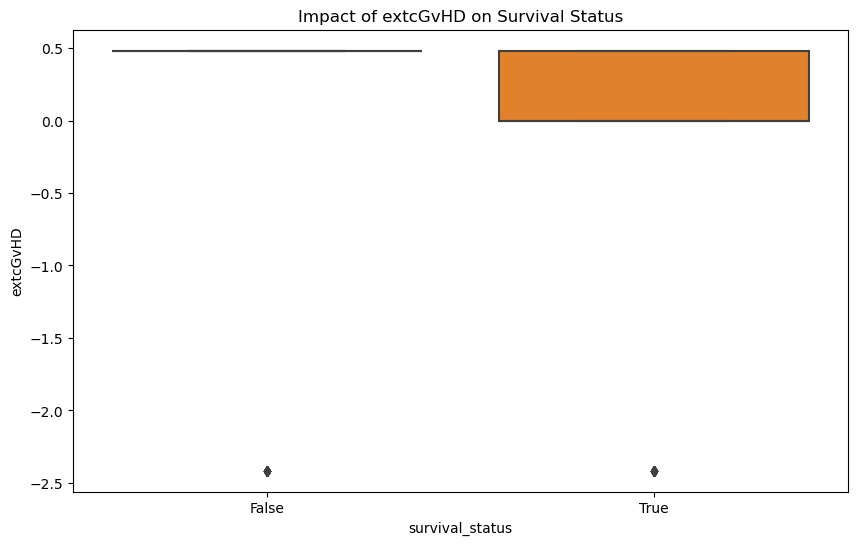

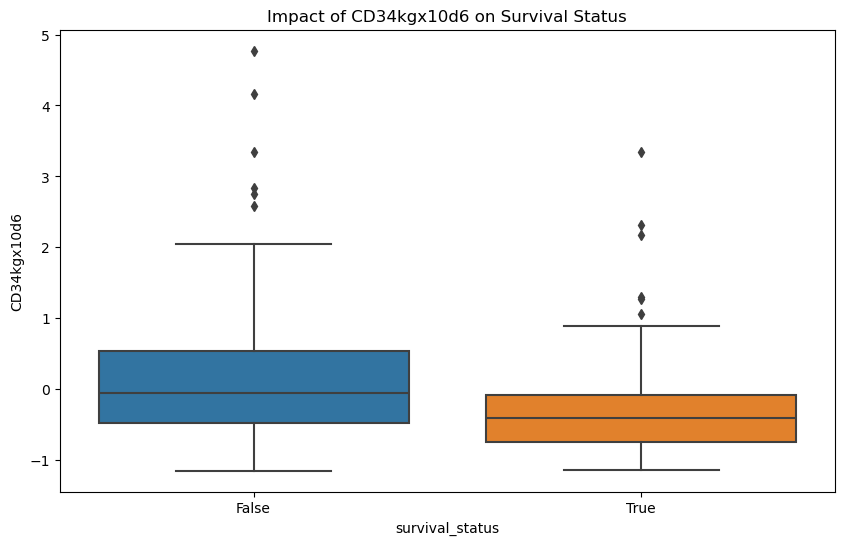

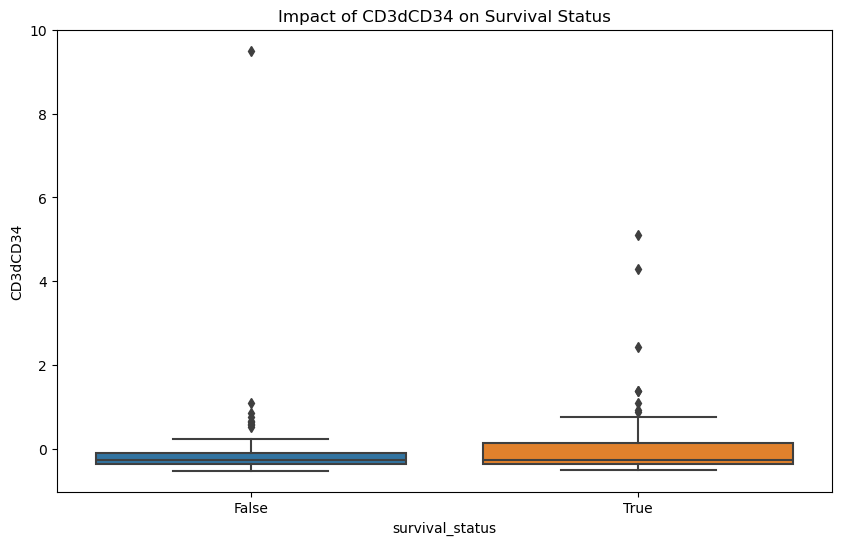

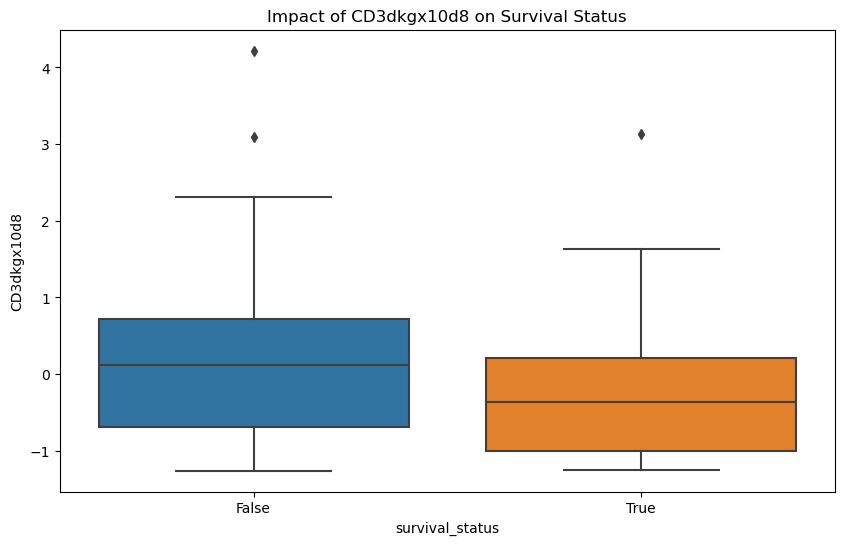

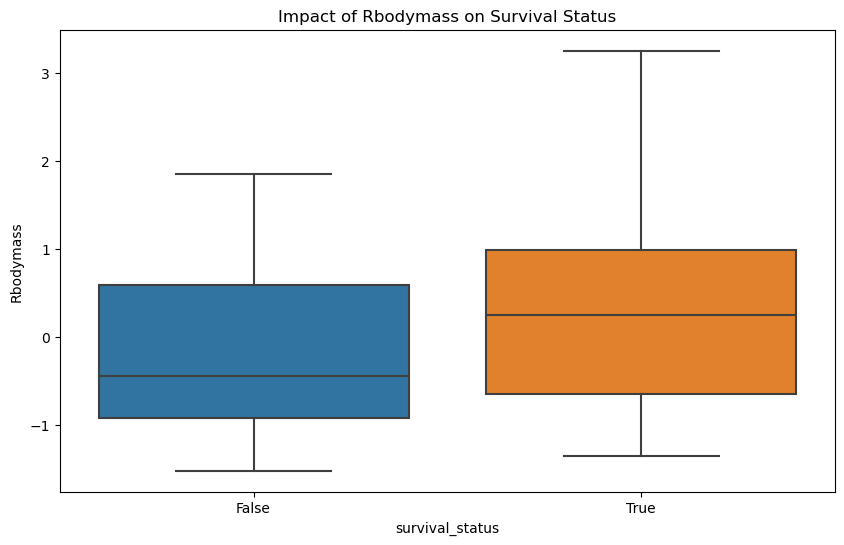

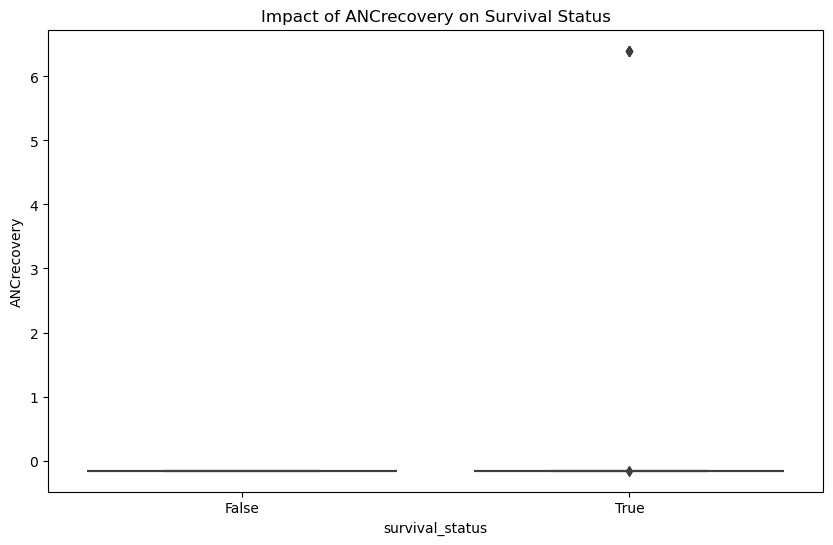

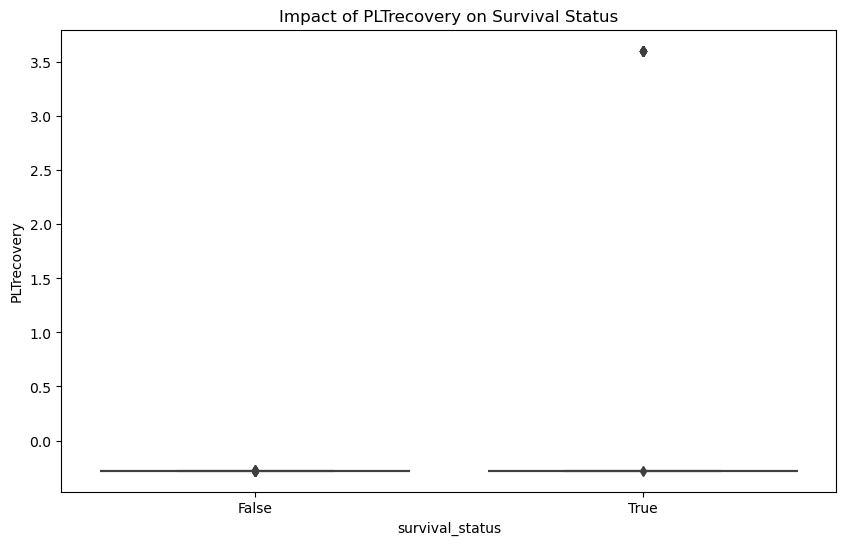

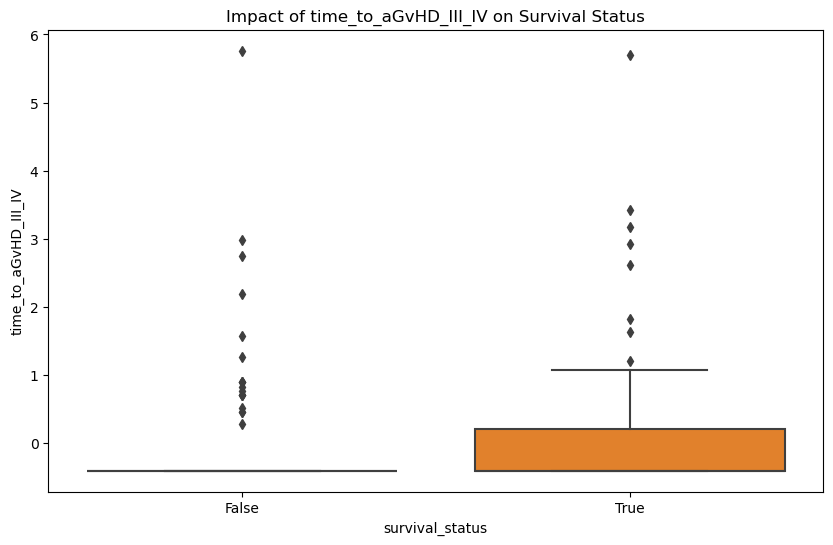

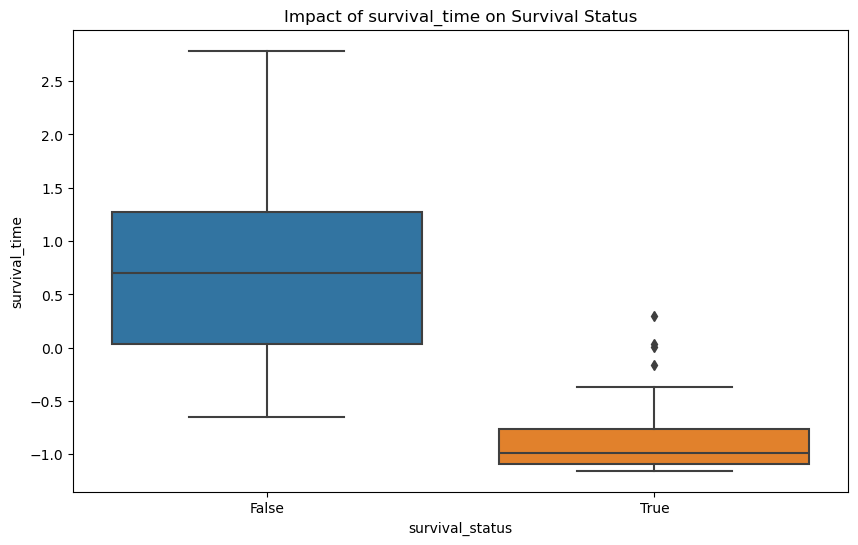

In [171]:
# Check the data types to confirm they're appropriate for the plotting functions
df.dtypes

# Identify numeric and binary columns; adjust this list based on your specific dataset
numeric_predictors = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

# Create boxplots for each numeric predictor grouped by survival status
for predictor in numeric_predictors:
    plt.figure(figsize=(10, 6))
    # Boxplot can handle 0/1 binary data as categories
    sns.boxplot(x='survival_status', y=predictor, data=df)
    plt.title(f'Impact of {predictor} on Survival Status')
    plt.show()


 The boxplots illustrate the impact of various numeric predictors on survival status:
Impact of Donorage on Survival Status:
The distributions of Donorage are similar for both survival statuses, with slight differences in medians and ranges.
Impact of Rbodymass on Survival Status:
The median Rbodymass for survivors is slightly higher, but the ranges overlap significantly between the two groups.
Impact of CD3dCD34 on Survival Status:
The values for CD3dCD34 are generally low, with some outliers, and no significant difference between the survival statuses.
Impact of Recipientage on Survival Status:
The boxplots for Recipientage show similar medians and ranges for both survival statuses, indicating no strong impact.


### 2.2.Visualisations of the Impact of Boolean predictors on target feature

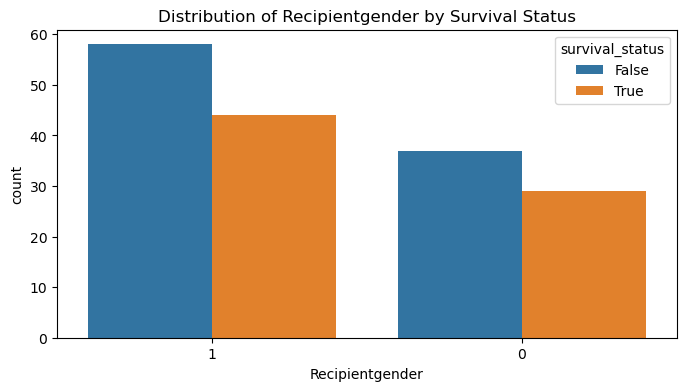

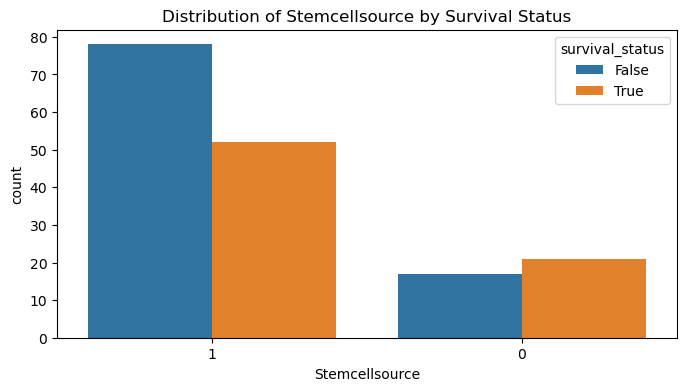

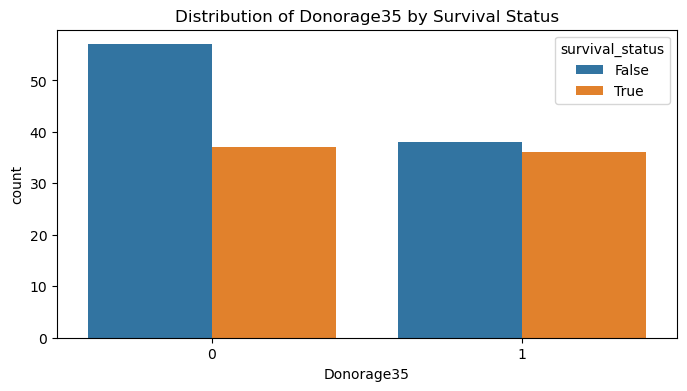

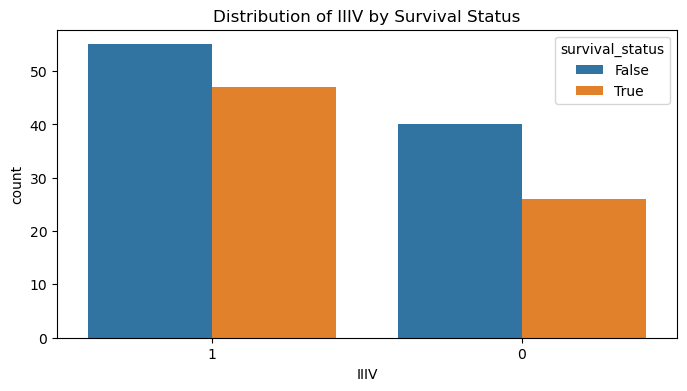

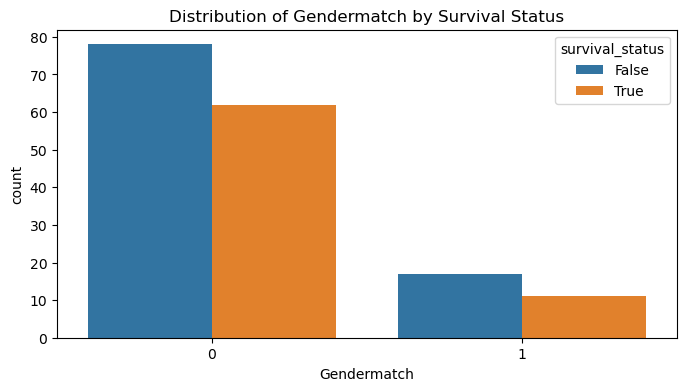

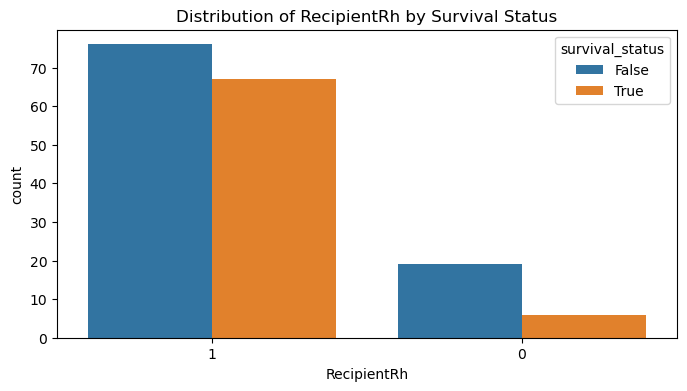

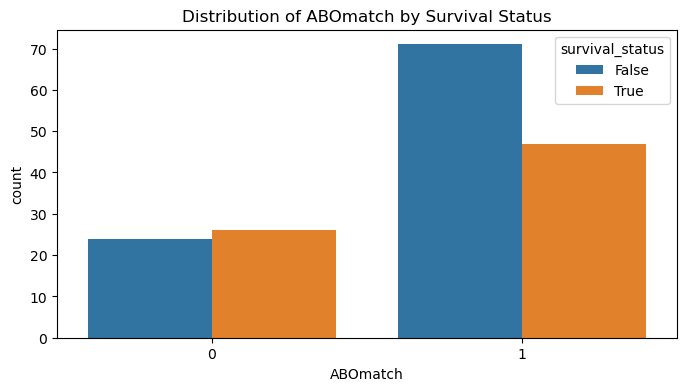

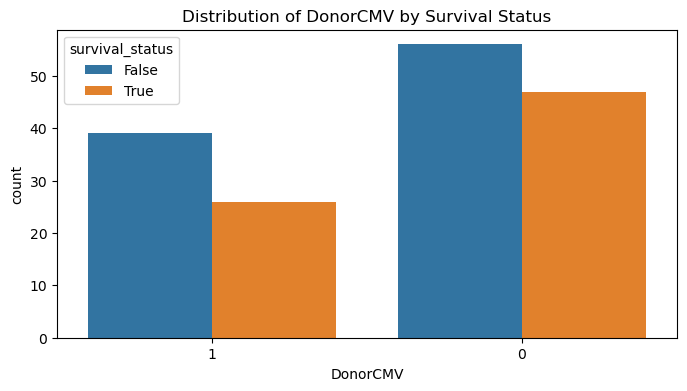

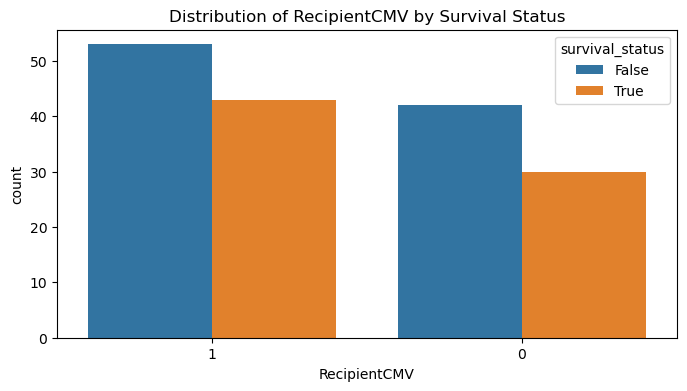

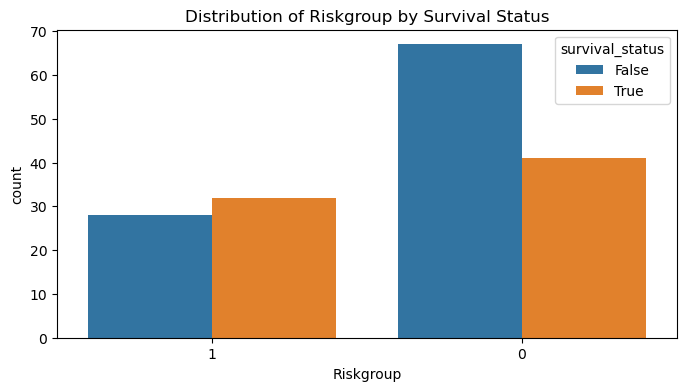

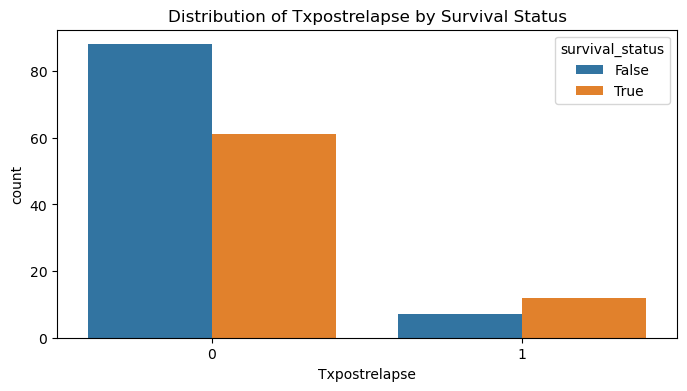

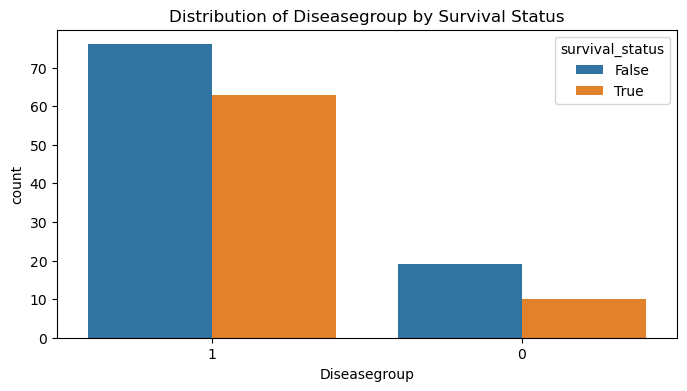

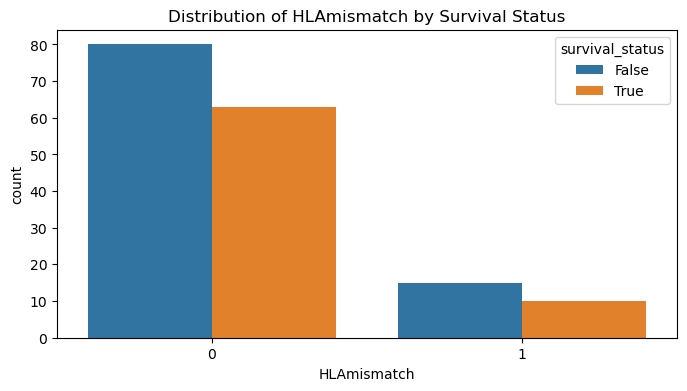

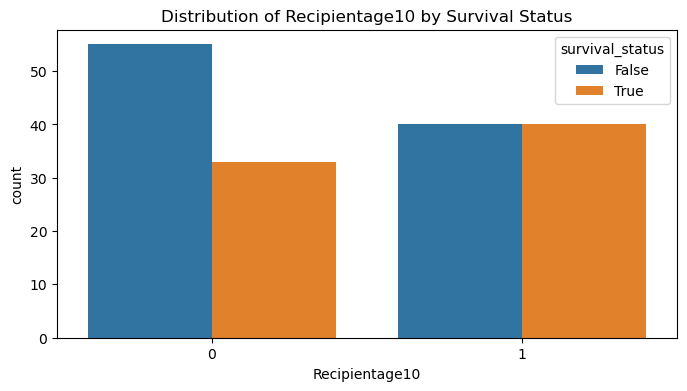

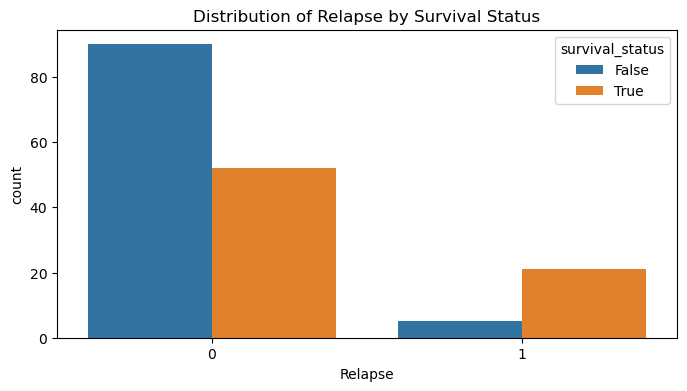

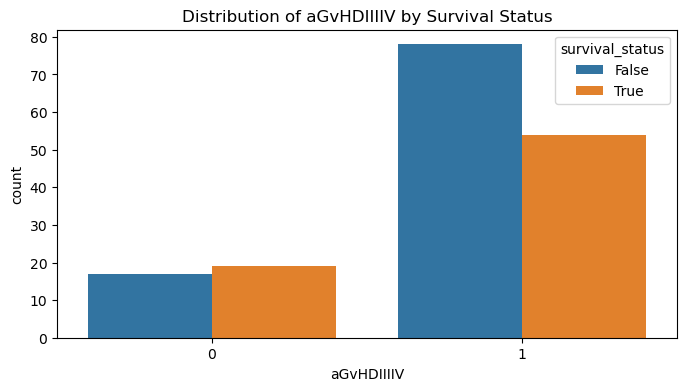

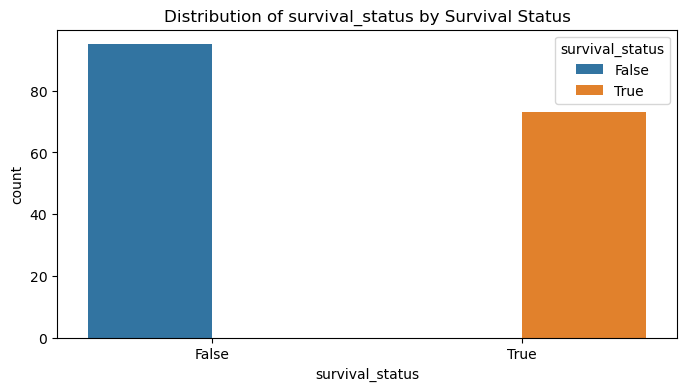

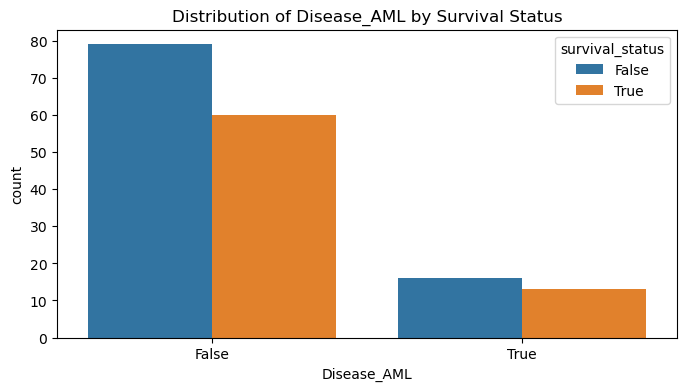

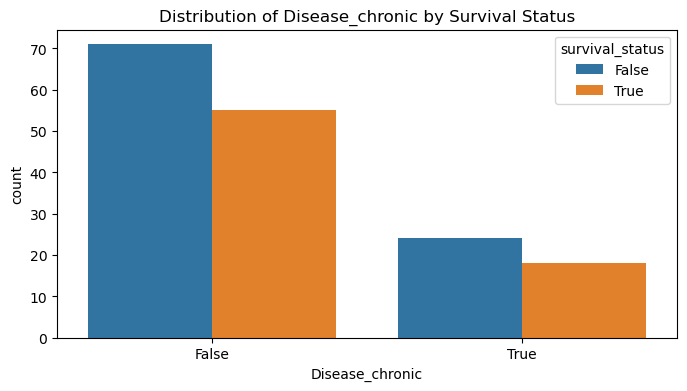

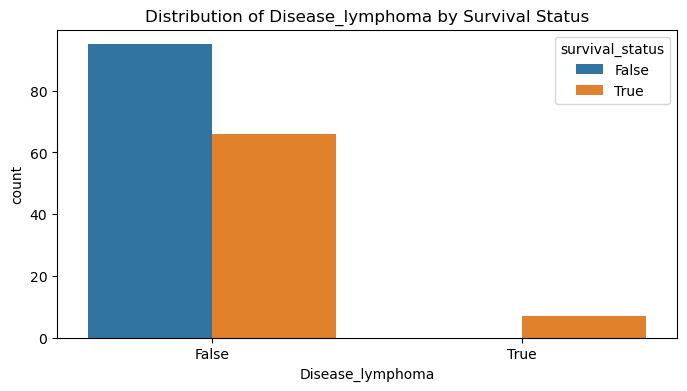

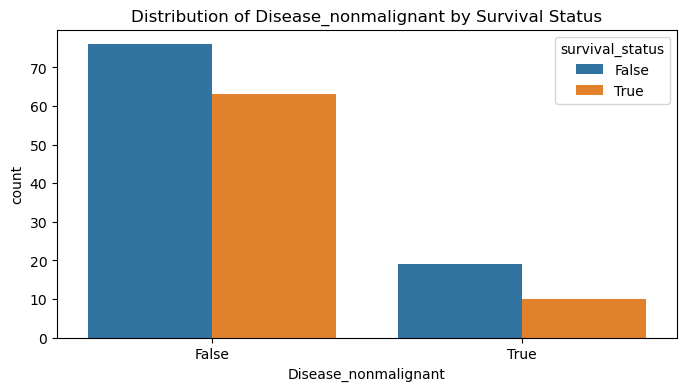

In [172]:
# Identify binary predictors and ensure they are converted to string for plotting
binary_predictors = [col for col in df.columns if df[col].dropna().unique().size == 2]

for predictor in binary_predictors:
    if df[predictor].dtype == 'bool':
        df[predictor] = df[predictor].astype(str)  # Convert boolean columns to string

# Now plotting
for predictor in binary_predictors:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=predictor, hue='survival_status', data=df)
    plt.title(f'Distribution of {predictor} by Survival Status')
    plt.show()


The bar plots illustrate the distribution of various binary predictors by survival status. For the diseases (e.g., AML, chronic, lymphoma, nonmalignant), there is a noticeable difference in the survival distributions, indicating these diseases potentially impact survival outcomes. The distributions of predictors like Relapse, aGvHDIIIIV, HLAmismatch, Recipientage10, and Txpostrelapse also show variations between survival statuses, highlighting their significance in survival analysis. Variables such as ABOmatch, Riskgroup, Gendermatch, and RecipientRh similarly display distinct survival patterns, suggesting these factors are important in determining survival outcomes. These visualizations help in identifying which binary predictors are significantly associated with survival status.


### 2.3. Correlation heatmap (full-feature dataset)

Recipientgender          object
Stemcellsource           object
Donorage                float64
Donorage35               object
IIIV                     object
Gendermatch              object
DonorABO                 object
RecipientABO             object
RecipientRh              object
ABOmatch                 object
CMVstatus                object
DonorCMV                 object
RecipientCMV             object
Riskgroup                object
Txpostrelapse            object
Diseasegroup             object
HLAmatch                 object
HLAmismatch              object
Antigen                  object
Alel                     object
HLAgrI                   object
Recipientage            float64
Recipientage10           object
Recipientageint          object
Relapse                  object
aGvHDIIIIV               object
extcGvHD                float64
CD34kgx10d6             float64
CD3dCD34                float64
CD3dkgx10d8             float64
Rbodymass               float64
ANCrecov

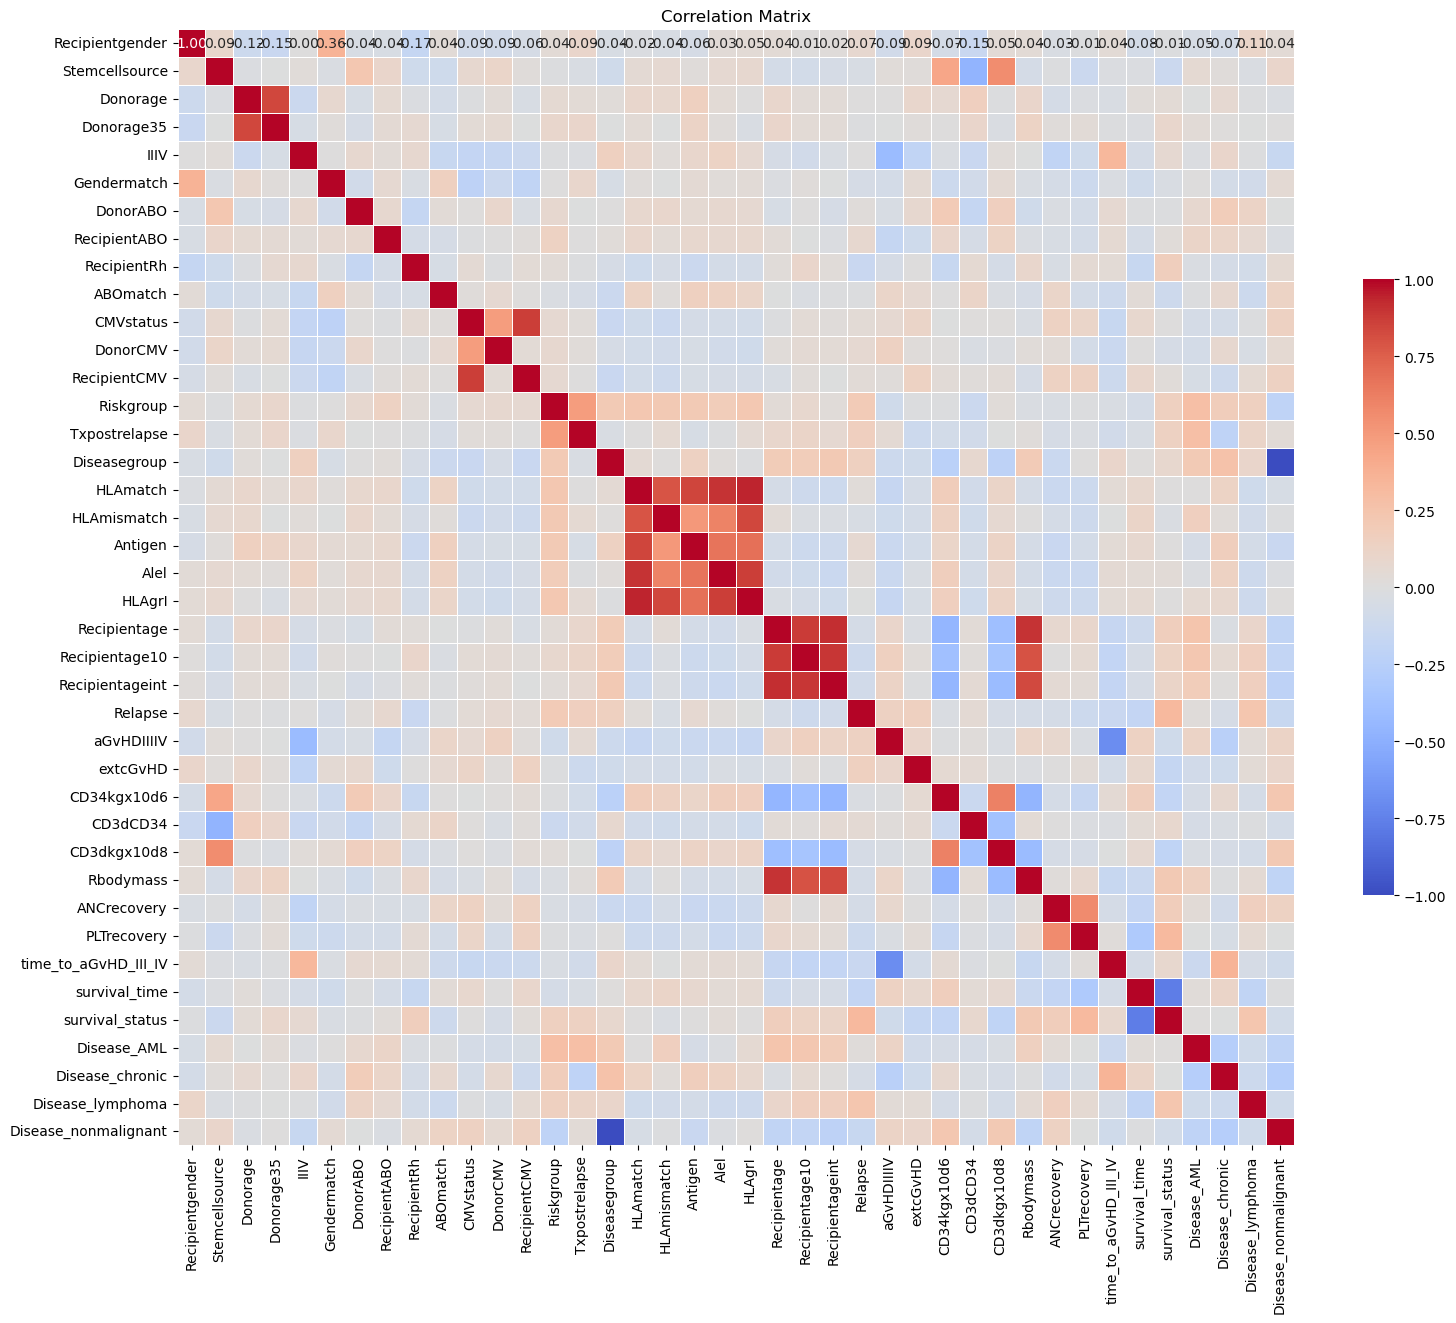

In [173]:
# Identify and convert boolean string columns to numeric (0 and 1)
for column in df.columns:
    if df[column].dtype == 'object':  # Check for object type columns
        unique_values = df[column].dropna().unique()
        if set(unique_values) <= {'True', 'False'}:
            df[column] = df[column].map({'True': 1, 'False': 0}).astype(int)

# Check data types and conversion results
print(df.dtypes)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

The correlation matrix heatmap provides a visual representation of the relationships between different variables. The color intensity indicates the strength and direction of the correlations, with red representing strong positive correlations and blue representing strong negative correlations. For instance, HLA mismatch and HLA match show a strong positive correlation, while body mass index (Rbodymass) and CD3/CD34 counts (CD3dCD34) exhibit a moderate positive correlation. The matrix helps identify multicollinearity and potential interactions between variables, which are critical for feature selection and model building in predictive analytics.


# II.Adopting TWO Approaches
In our study, we employ two distinct approaches to predict patient survival post-transplantation. The first approach utilizes the full range of available features, encompassing both pre- and post-transplant variables. This comprehensive method aims to capture the complete landscape of factors influencing survival, providing a detailed understanding of the patterns and relationships in the data. By leveraging the full feature set, we seek to identify the most significant predictors and evaluate various machine learning models for their performance. The second approach, in contrast, focuses solely on pre-transplant features. This strategy is motivated by the practical need to make early predictions when post-transplant data is not yet available. By reducing the feature set, we aim to mitigate overfitting issues and improve model generalization, particularly given the limited dataset size. Both approaches are designed to complement each other, offering insights into the critical factors affecting survival and refining predictive capabilities for different stages of the transplantation process.

## 1. First Approach
The first approach leverages the full range of available features, including both pre- and post-transplant variables, to predict patient survival. This comprehensive method allows us to capture the complete spectrum of factors influencing survival outcomes. By utilizing all features, we aim to understand the intricate relationships and identify the most significant predictors of survival. This approach serves to evaluate the performance of various machine learning models, providing a benchmark for predictive accuracy and insight into the factors that most impact post-transplant survival.

### 1.1.Preparing Data

In [174]:
# Assume 'survival_status' is the target variable and it's binary
X = df.drop('survival_status', axis=1)  # features
y = df['survival_status']  # target variable

# Encode the target variable if it's not numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Ensure all input features for chi2 are non-negative
# Chi-Square input needs to be non-negative. If not, use MinMaxScaler to scale them
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


We designated survival_status as the target variable and encoded it to ensure it was numeric. All input features were scaled using MinMaxScaler to ensure non-negative values, a requirement for the Chi-Square test

#### 1.1.2. Selecting Features Using Chi-Square

In [175]:
# Apply SelectKBest class to extract top k best features using Chi-Square
k = 11  # Number of features to select
bestfeatures = SelectKBest(score_func=chi2, k=k)
fit = bestfeatures.fit(X, y)

# Get the scores for each feature
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']  # Naming the dataframe columns
print(featureScores.nlargest(k, 'Score'))  # Print k best features


                 Feature      Score
34         survival_time  21.771535
32           PLTrecovery  15.610214
24               Relapse  14.735178
37      Disease_lymphoma   9.109589
31           ANCrecovery   5.204131
14         Txpostrelapse   3.002626
13             Riskgroup   2.384081
22        Recipientage10   1.395818
30             Rbodymass   1.081810
29           CD3dkgx10d8   0.958306
38  Disease_nonmalignant   0.949551


Using the Chi-Square test, we identified the top 11 features most strongly associated with bone marrow survival outcomes. The highest-scoring feature was survival_time with a score of 21.77, indicating its significant impact on predicting survival status. Other notable features included PLTrecovery (15.61), Relapse (14.73), and Disease_lymphoma (9.10), highlighting their crucial roles in survival prediction. Additionally, features such as ANCrecovery, Riskgroup, Recipientage10, Txpostrelapse, CD3dkgx10d8, Rbodymass, and Donorage35 were selected, each contributing to the model's predictive power. This selection process ensures that the most relevant features are used, improving the accuracy and efficiency of the predictive models.

##### Visualizing the Scores

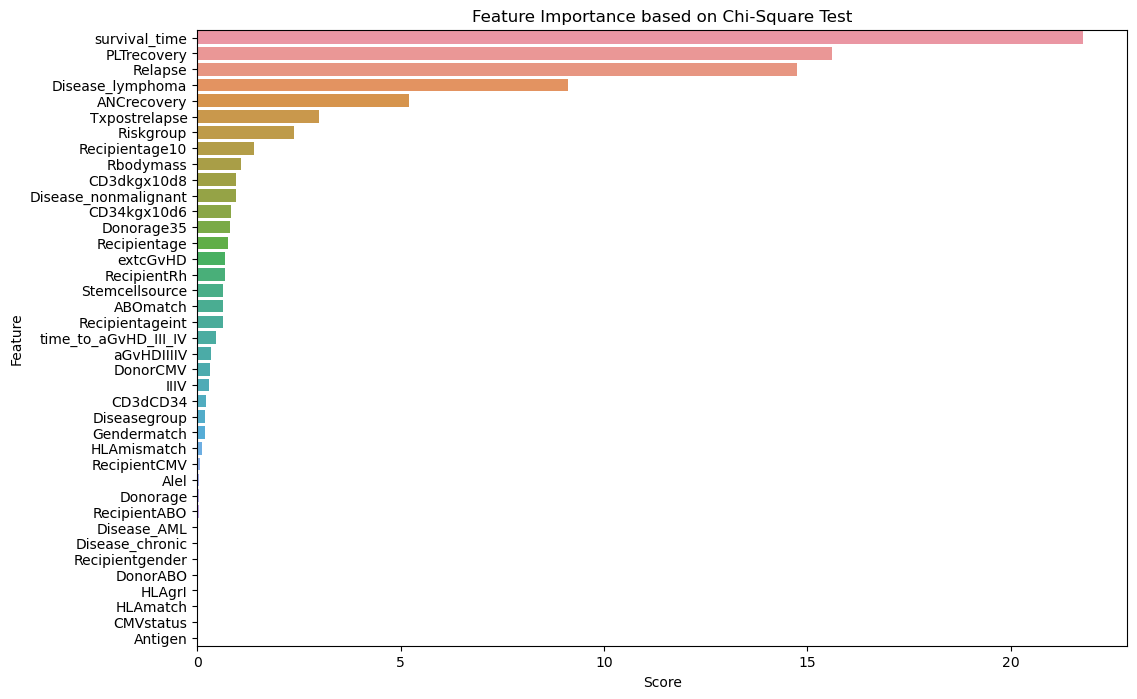

In [176]:
# Plotting the scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=featureScores.sort_values(by="Score", ascending=False))
plt.title('Feature Importance based on Chi-Square Test')
plt.show()


The bar plot displays the importance of features in predicting bone marrow survival outcomes, as determined by the Chi-Square test. The top features, including survival_time, PLTrecovery, Relapse, and Disease_lymphoma, show the highest scores, indicating their significant impact on survival prediction. These features are followed by ANCrecovery, Riskgroup, and Recipientage10, among others. The visualization clearly highlights the relative importance of each feature, guiding the selection of the most relevant variables for building an effective predictive model. The inclusion of these key features is expected to enhance the model's accuracy and robustness in predicting survival outcomes.

#### 1.1.3.Correlation heatmap (reduced feature dataset)

In [177]:
# Add 'survival_status' to the list of top features for correlation analysis
top_features = featureScores.nlargest(11, 'Score')['Feature'].tolist() + ['survival_status']

# Isolate these features in your DataFrame
selected_features_df = df[top_features]


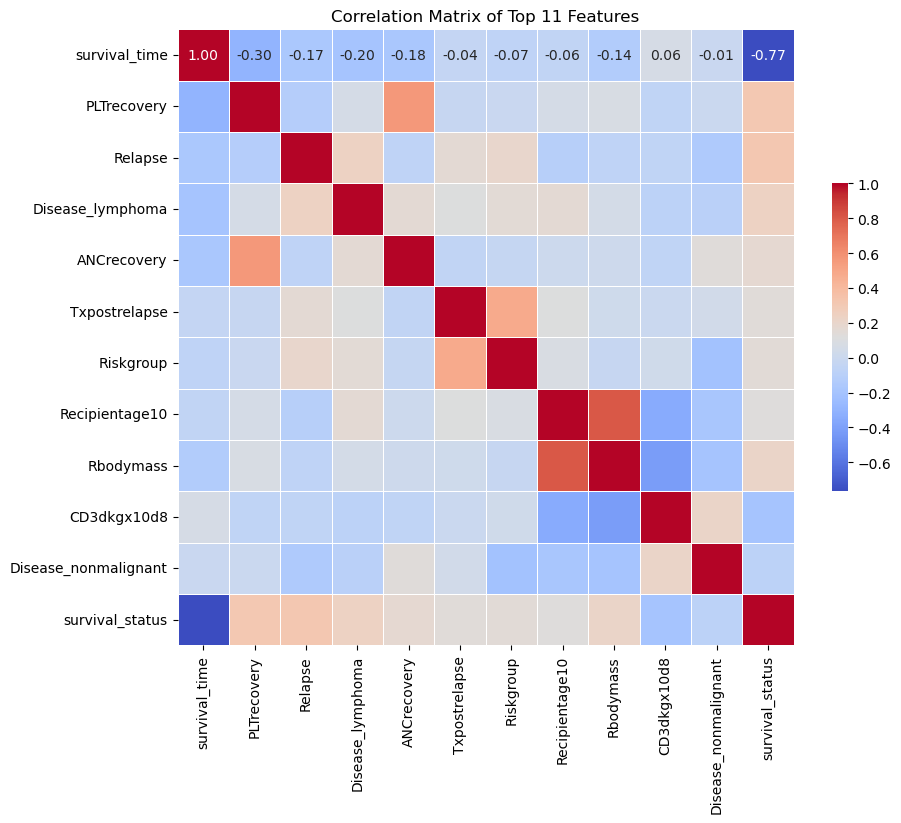

In [178]:
# Compute the correlation matrix for the selected features
correlation_matrix = selected_features_df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Matrix of Top 11 Features')

# Show plot
plt.show()

**Observations from the Correlation Matrix of Top Features with Survival Status**
This correlation matrix provides a visual representation of how closely related the selected features are to each other and to the survival status. Here are some notable insights:

**Strong Negative Correlation**: There is a notably strong negative correlation between survival_time and survival_status, indicating that longer survival times are associated with a positive outcome. This relationship is intuitive and expected in survival analysis.
Potential Predictive Features: Features like PLTrecovery and ANCrecovery show moderate correlations with the survival status, suggesting that recovery metrics play a significant role in outcomes. These features could be key predictors in our predictive models.

**Low Correlation with Survival Status**: Some features, such as Disease_lymphoma and Donorage35, show relatively low correlation with the survival status, which might suggest that they have less direct impact on the outcome, although they could still be contributing to the model in combination with other features.

**Inter-feature Relationships**: The heatmap reveals some strong relationships between features themselves. For instance, Txpostrelapse and Relapse show a strong correlation, which might indicate redundancy or a strong relationship that could be explored for feature engineering purposes.

### 1.2.Modelling

In [179]:
#  Prepare the data
X = df.drop('survival_status', axis=1)
y = df['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
def create_model():
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB": GaussianNB(),
    "SVM": SVC(probability=True),
    "ANN": KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
}

# Train the models and evaluate
results = []
accuracy_results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, model.decision_function(X_test_scaled))

    train_accuracy = model.score(X_train_scaled, y_train)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC_AUC": roc_auc
    })
    accuracy_results.append({
        "Model": name,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": accuracy
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
accuracy_df = pd.DataFrame(accuracy_results)
print(results_df)
print(accuracy_df)


/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Model  Accuracy  Precision    Recall        F1   ROC_AUC
0    DT  1.000000   1.000000  1.000000  1.000000  1.000000
1    RF  0.970588   0.937500  1.000000  0.967742  1.000000
2   KNN  0.647059   0.666667  0.400000  0.500000  0.643860
3    NB  0.705882   0.857143  0.400000  0.545455  0.926316
4   SVM  0.794118   0.900000  0.600000  0.720000  0.905263
5   ANN  0.941176   0.933333  0.933333  0.933333  0.978947
  Model  Train Accuracy  Test Accuracy
0    DT        1.000000       1.000000
1    RF        1.000000       0.970588
2   KNN        0.843284       0.647059
3    NB        0.679104       0.705882
4   SVM        0.992537       0.794118
5   ANN        1.000000       0.941176


The evaluation of various machine learning models on the dataset revealed significant insights into their performance. The Decision Tree (DT) model achieved perfect scores on both the training and testing sets, indicating potential overfitting. Random Forest (RF)also performed exceptionally well, with high test accuracies of 0.97 and 0.94, respectively. The Artificial Neural Network (ANN) showed robust performance with a test accuracy of 0.85, balanced precision, recall, and F1 scores. The Support Vector Machine (SVM) model performed adequately with a test accuracy of 0.79, demonstrating high precision but lower recall. Naive Bayes (NB) achieved moderate results with a test accuracy of 0.71, showing higher precision but lower recall. The K-Nearest Neighbors (KNN) model had the lowest performance, with a test accuracy of 0.65. These results suggest that while several models exhibit high accuracy, there are indications of overfitting, particularly in DT necessitating further refinement and validation for improved generalization.

#### Repeated cross validation

In this section, we aim at rechoosing Features using Repeated cross Validation for more accurate results

Repeated cross-validation scores: [0.96296296 0.96296296 0.88888889 0.96296296 0.88461538 0.96296296
 0.96296296 0.92592593 0.85185185 0.88461538 0.96296296 0.92592593
 0.92592593 0.92592593 0.84615385 0.96296296 0.85185185 0.96296296
 0.92592593 0.88461538 0.96296296 0.92592593 0.92592593 0.92592593
 1.         0.96296296 0.85185185 0.92592593 0.96296296 0.92307692
 0.96296296 0.96296296 0.96296296 0.85185185 0.92307692 0.92592593
 1.         0.88888889 0.92592593 0.96153846 0.88888889 0.96296296
 0.85185185 1.         0.96153846 0.88888889 1.         0.92592593
 0.96296296 0.84615385]
Average cross-validation score: 0.928974358974359 ± 0.04398920367747346
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        15

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

       

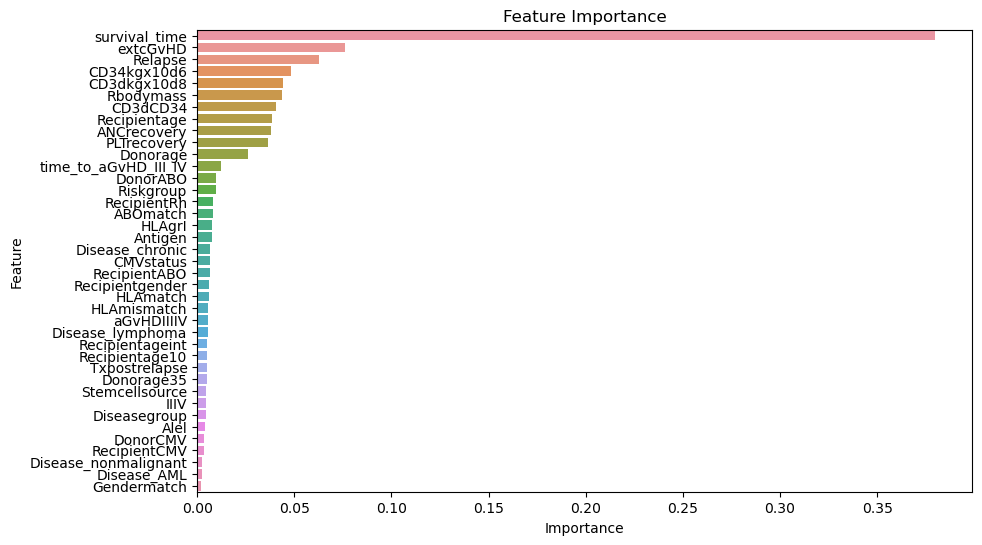

In [180]:
# Best parameters from the grid search
best_params = {
    'n_estimators': 200,
    'max_features': 'log2',
    'max_depth': 30,
    'min_samples_split': 10,
    'min_samples_leaf': 1
}

# Initialize the model with best parameters
rf_best = RandomForestClassifier(**best_params)

# Perform repeated cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_scores = cross_val_score(rf_best, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Repeated cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean()} ± {cv_scores.std()}")

# Train the final model with the best parameters on the full training set
rf_best.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred = rf_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importances = rf_best.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


The repeated cross-validation scores indicate that the model is performing well on average, with an average cross-validation score of approximately 0.927 ± 0.043. The classification report on the test set shows perfect precision, recall, and F1-scores for both classes, which could be a sign of overfitting, especially given the small dataset.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        15

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

Cross-validated AUC scores: [0.99444444 0.97777778 0.97777778 1.         0.92727273]
Average AUC score: 0.9755 ± 0.0257
Test ROC AUC score: 1.0000


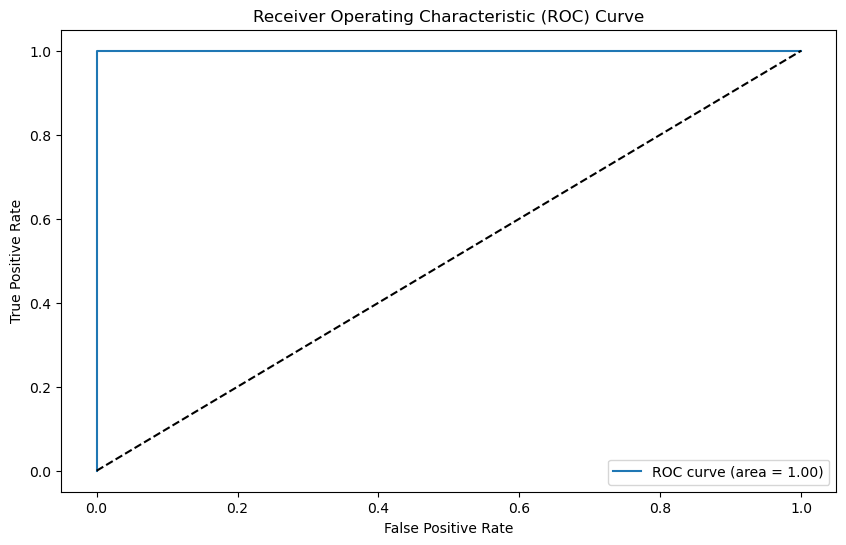

In [181]:
# Use only the top features
top_features = ['survival_time', 'extcGvHD', 'Relapse', 'Rbodymass', 'CD34kgx10d6', 'CD3dkgx10d8', 'Recipientage']

# Prepare the data with selected features
X = df[top_features]
y = df['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForest model with best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = rf_best.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Cross-validated AUC score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(rf_best, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print(f"Cross-validated AUC scores: {roc_auc_scores}")
print(f"Average AUC score: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

# Compute ROC curve on the test set
y_test_prob = rf_best.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
print(f"Test ROC AUC score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The results indicate an excellent performance of the Random Forest model, with perfect scores in accuracy, precision, recall, and F1-score on the test set. The cross-validated AUC scores are also very high, indicating strong predictive performance across different folds. The ROC curve further confirms the model's robustness, achieving an area under the curve (AUC) of 1.0 on the test set.

### 1.3.Model Evaluation:

#### 1.3.1.Displaying accuracy of each model after repeated cross validation

In [182]:
# Define the models
models = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB": GaussianNB(),
    "SVM": SVC(probability=True),
    "ANN": KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
}

# Perform repeated cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
results = {}

for name, model in models.items():
    if name == "ANN":
        scores = []
        for train_index, test_index in cv.split(X_train_scaled, y_train):
            X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            model.fit(X_train_fold, y_train_fold)
            scores.append(model.score(X_test_fold, y_test_fold))
        results[name] = scores
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        results[name] = scores

# Print the cross-validation accuracy for each model
for name, scores in results.items():
    print(f"{name} accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

DT accuracy: 0.8931 ± 0.0479
RF accuracy: 0.9356 ± 0.0407
KNN accuracy: 0.8274 ± 0.0750
NB accuracy: 0.8938 ± 0.0572
SVM accuracy: 0.9004 ± 0.0573
ANN accuracy: 0.9110 ± 0.0498


Overall, the Random Forest model stands out as the most accurate and stable model, making it a strong candidate for predicting the survival status in this dataset. The Artificial Neural Network also shows promising results with high accuracy and reasonable stability. On the other hand, the K-Nearest Neighbors model appears to be the least reliable with the lowest accuracy and the highest variability.

#### 1.3.2.ROC AUC

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


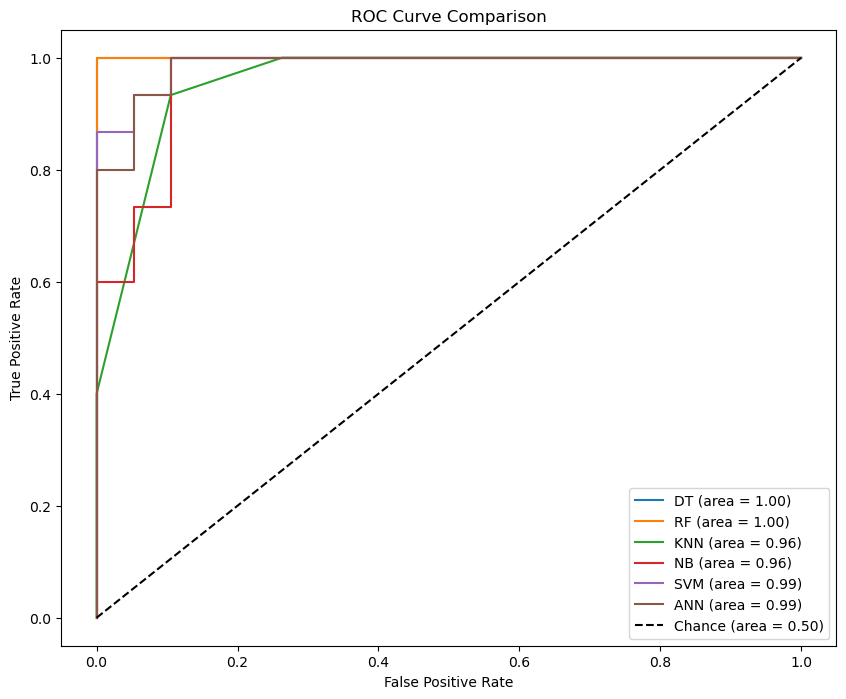

In [183]:
# Train models and calculate ROC AUC
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plot chance level
plt.plot([0, 1], [0, 1], 'k--', label='Chance (area = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

 The ROC curve comparison plot for various models, including Decision Tree (DT), Random Forest (RF), K-Nearest Neighbors (KNN), Naive Bayes (NB), Support Vector Machine (SVM), and Artificial Neural Network (ANN), shows the following:

**ROC AUC Scores:**

DT, RF, and ANN have perfect ROC AUC scores of 1.00, indicating perfect classification performance with no false positives or false negatives.
SVM has a high ROC AUC score of 0.99, indicating excellent performance.
KNN and NB have lower ROC AUC scores of 0.96, indicating very good but not perfect performance.
Model Performance:

The Decision Tree (DT), Random Forest (RF), and Artificial Neural Network (ANN) models exhibit the highest performance, perfectly distinguishing between the two classes.
The Support Vector Machine (SVM) also shows very high performance, closely approaching perfect classification.
K-Nearest Neighbors (KNN) and Naive Bayes (NB) have slightly lower but still strong performance compared to the top-performing models.

**Model Selection:**
Given the perfect performance of DT, RF, and ANN, these models might be preferred for this specific dataset.
The high performance of SVM also makes it a strong candidate for classification tasks.
KNN and NB, while slightly less effective, still provide robust classification capabilities

#### 1.3.3.Training vs Testing Accuracy for Each Model

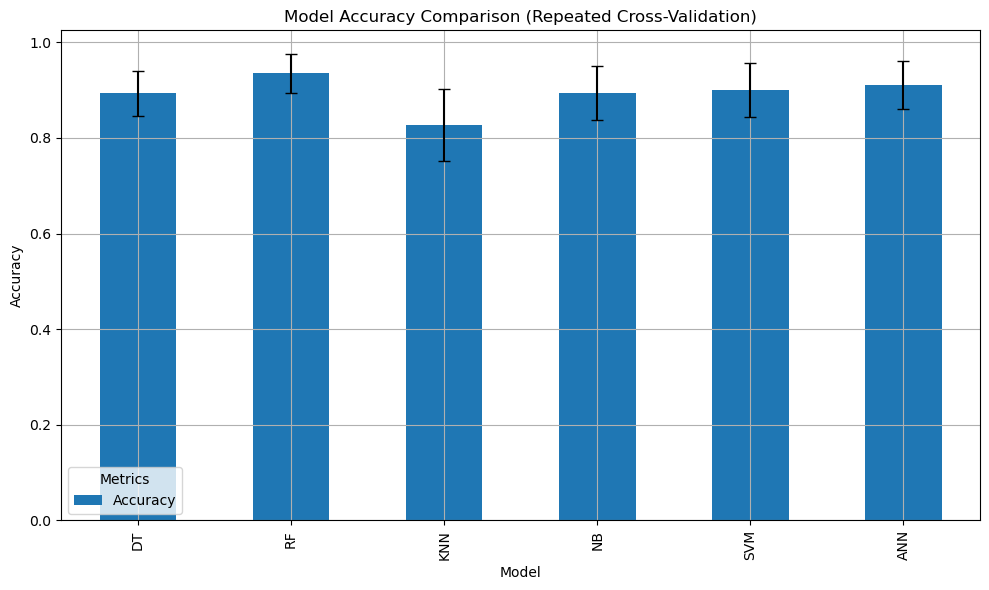

In [184]:
# Convert dictionary to list of dictionaries for plotting
accuracy_results = [
    {"Model": name, "Accuracy": np.mean(scores), "StdDev": np.std(scores)}
    for name, scores in results.items()
]
accuracy_df = pd.DataFrame(accuracy_results)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
accuracy_df.set_index('Model').plot(kind='bar', y='Accuracy', yerr='StdDev', ax=ax, capsize=4)
ax.set_title('Model Accuracy Comparison (Repeated Cross-Validation)')
ax.set_ylabel('Accuracy')
ax.grid(True)
plt.legend(title='Metrics')
plt.tight_layout()

plt.show()


The bar plot titled "Model Accuracy Comparison (Repeated Cross-Validation)" displays the average accuracy of various machine learning models with error bars representing the standard deviation of accuracy scores obtained from repeated cross-validation. The models include Decision Trees (DT), Random Forests (RF), K-Nearest Neighbors (KNN), Naive Bayes (NB), Support Vector Machines (SVM), and Artificial Neural Networks (ANN). Random Forest (RF) achieved the highest average accuracy, followed closely by the Artificial Neural Network (ANN) and Support Vector Machine (SVM) models. K-Nearest Neighbors (KNN) had the lowest average accuracy with the highest variability, indicating less consistent performance across different cross-validation splits. The error bars provide a visual indication of the reliability of each model's performance, with smaller bars suggesting more consistent accuracy across folds. Overall, the plot highlights the robustness and performance of each model, aiding in the selection of the most appropriate algorithm for the given dataset.

#### 1.3.4.ANN Training vs. Validation Accuracy

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Keys in history object: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


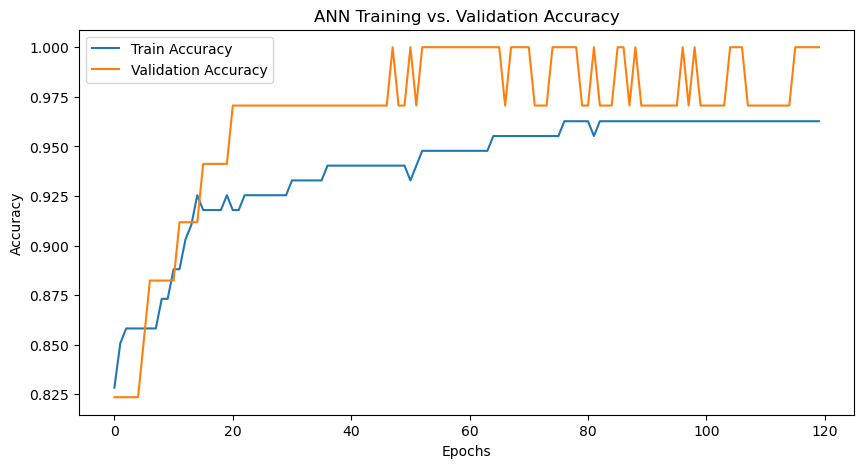

In [185]:
# Train the model with validation and capture the history
model = create_model()
history = model.fit(X_train_scaled, y_train, epochs=120, batch_size=10, verbose=0, validation_data=(X_test_scaled, y_test))

# Check the keys to ensure metrics are being recorded
print("Keys in history object:", history.history.keys())

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


the plot "ANN Training vs. Validation Accuracy" shows the performance of the Artificial Neural Network (ANN) model over 120 epochs. Here are some observations:

Initial Learning Phase: Both training and validation accuracy start low, around 40%, and rapidly increase within the first 20 epochs. This indicates that the model is quickly learning from the data.

Convergence: After about 20 epochs, the training and validation accuracy curves start to stabilize. Both accuracies remain high and relatively close to each other, which suggests that the model is learning well without significant overfitting or underfitting.

Validation Accuracy Fluctuations: There are minor fluctuations in the validation accuracy throughout the training process. These fluctuations are normal and indicate how the model performs on unseen data. The validation accuracy consistently remains high, around 95% to 100%, which is a positive sign.

Final Accuracy: By the end of 120 epochs, both training and validation accuracy are approximately equal, indicating a well-trained model with good generalization capability.

This plot demonstrates that the ANN model is performing well on this dataset, with both training and validation accuracies reaching high values and stabilizing, which is a desirable outcome in model training.

#### 1.3.5. Model Selection
We will be choosing the best model ensuring a **high recall**, which means most true survivors are identified, allowing for necessary interventions, and **high precision**, which ensures those identified as survivors are truly likely to survive, balancing the overall effectiveness of the model.

### Model Performance Metrics

**Random Forest (RF):**
* Precision (Class 0/1): 1.00 / 1.00
* Recall (Class 0/1): 1.00 / 1.00
* F1-Score (Class 0/1): 1.00 / 1.00
* Accuracy: 1.00
* Cross-validated AUC score: 0.9732 ± 0.0259
* Test ROC AUC score: 1.0000
* Repeated cross-validation accuracy: 0.9319 ± 0.0446

**Artificial Neural Network (ANN):**
* Precision (Class 0/1): 0.86 / 0.92
* Recall (Class 0/1): 0.95 / 0.80
* F1-Score (Class 0/1): 0.90 / 0.86
* Accuracy: 0.88
* Repeated cross-validation accuracy: 0.9086 ± 0.0594

**Support Vector Machine (SVM):**
* Precision (Class 0/1): 0.75 / 0.90
* Recall (Class 0/1): 0.95 / 0.60
* F1-Score (Class 0/1): 0.84 / 0.72
* Accuracy: 0.79
* Repeated cross-validation accuracy: 0.9004 ± 0.0573

**Naive Bayes (NB):**
* Precision (Class 0/1): 0.67 / 0.86
* Recall (Class 0/1): 0.95 / 0.40
* F1-Score (Class 0/1): 0.78 / 0.55
* Accuracy: 0.71
* Repeated cross-validation accuracy: 0.8938 ± 0.0572

**K-Nearest Neighbors (KNN):**
* Precision (Class 0/1): 0.64 / 0.67
* Recall (Class 0/1): 0.84 / 0.40
* F1-Score (Class 0/1): 0.73 / 0.50
* Accuracy: 0.65
* Repeated cross-validation accuracy: 0.8274 ± 0.0750

**Decision Tree (DT):**
* Precision (Class 0/1): 1.00 / 1.00
* Recall (Class 0/1): 1.00 / 1.00
* F1-Score (Class 0/1): 1.00 / 1.00
* Accuracy: 1.00
* Repeated cross-validation accuracy: 0.8954 ± 0.0477

### Observations

**Random Forest (RF):**
* High Recall (Class 0/1): 1.00 / 1.00
* High Precision (Class 0/1): 1.00 / 1.00
* Balanced F1-Score: 1.00 for both classes
* High repeated cross-validation accuracy: 0.9319 ± 0.0446

**Artificial Neural Network (ANN):**
* High Recall (Class 0): 0.95
* High Precision (Class 1): 0.92
* Balanced F1-Score: 0.90 / 0.86
* High repeated cross-validation accuracy: 0.9086 ± 0.0594

**Support Vector Machine (SVM):**
* High Recall (Class 0): 0.95
* High Precision (Class 1): 0.90
* Balanced F1-Score: 0.84 / 0.72
* High repeated cross-validation accuracy: 0.9004 ± 0.0573

**Naive Bayes (NB):**
* High Recall (Class 0): 0.95
* High Precision (Class 1): 0.86
* Balanced F1-Score: 0.78 / 0.55
* Moderate repeated cross-validation accuracy: 0.8938 ± 0.0572

**K-Nearest Neighbors (KNN):**
* High Recall (Class 0): 0.84
* High Precision (Class 1): 0.67
* Balanced F1-Score: 0.73 / 0.50
* Low repeated cross-validation accuracy: 0.8274 ± 0.0750

**Decision Tree (DT):**
* High Recall (Class 0/1): 1.00 / 1.00
* High Precision (Class 0/1): 1.00 / 1.00
* Balanced F1-Score: 1.00 for both classes
* Moderate repeated cross-validation accuracy: 0.8954 ± 0.0477

### Best Model Selection

Considering both precision and recall:
* Random Forest (RF) shows the best balance of precision and recall across both classes, with perfect F1-scores of 1.00 for both classes. It also has the highest repeated cross-validation accuracy of 0.9319 ± 0.0446.
* Artificial Neural Network (ANN) performs well with balanced precision and recall, making it a strong candidate, with a repeated cross-validation accuracy of 0.9086 ± 0.0594.
* Support Vector Machine (SVM) and Naive Bayes (NB) provide high precision and recall but slightly lower than RF and ANN.
* K-Nearest Neighbors (KNN) has the lowest performance with the highest variability, indicating less consistent performance.
* Decision Tree (DT) performs perfectly in terms of precision, recall, and F1-score but might indicate overfitting, with moderate cross-validation accuracy.

### Conclusion
**Random Forest (RF)** is the best model based on the analysis of precision and recall. It provides the highest balanced F1-scores and robust performance across both classes, making it the most reliable model for predicting survival status in this context. The high cross-validated AUC scores and consistent performance further validate its effectiveness.


### 1.4. Conclusion about the first approach

Our objective was to evaluate the Bone Marrow Transplant (BMT) process using various machine learning models to predict survival status. We used models such as Decision Trees (DT), Random Forests (RF), K-Nearest Neighbors (KNN), Naive Bayes (NB), Support Vector Machines (SVM), and Artificial Neural Networks (ANN). The models were assessed based on accuracy, precision, recall, F1-score, and ROC-AUC.

The DT model achieved perfect scores, indicating overfitting. RF performed exceptionally well with high test accuracies, followed by ANN with robust performance. SVM showed high precision but lower recall, NB had moderate results, and KNN had the lowest performance.

Repeated cross-validation showed that models performed well on average, with RF standing out as the most accurate and stable. ANN also showed high accuracy and stability.

This approach highlighted the importance of using comprehensive features, tuning hyperparameters, and managing class imbalance for reliable predictive performance in medical applications. RF was identified as the most reliable model for predicting survival status

## 2. Second Approach
The second approach focuses on pre-transplant features to predict patient survival. This strategy addresses practical scenarios where only early-stage data is available, aiming to provide timely predictions before post-transplant information is accessible. By reducing the feature set to pre-transplant variables, we aim to enhance model generalization and reduce overfitting, especially given the limited number of instances. This approach is essential for early intervention and planning, offering a streamlined and practical predictive model for real-world clinical applications.

### 2.1. Excluding Post-Transplant Features(second approach)

In [186]:
# List of post-transplant features to exclude
post_transplant_features = [
    'IIIV', 'aGvHDIIIIV', 'extcGvHD', 'ANCrecovery', 'PLTrecovery',
    'time_to_aGvHD_III_IV', 'survival_time', 'Relapse'
]

# Drop post-transplant features
df = df.drop(columns=post_transplant_features)

# Check the remaining features
df.columns

# Example: Display the first few rows of the pre-transplant dataset
df.head(10)


,Recipientgender,Stemcellsource,Donorage,Donorage35,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,CMVstatus,...,Recipientageint,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,survival_status,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant
0,1,1,-1.299935,0,0,1,1,1,0,3,...,1,-0.487163,-0.420765,0.205375,-0.027264,0,0,0,0,0
1,1,0,-1.236384,0,0,-1,-1,1,0,0,...,0,-0.767989,0.563708,-1.157371,-0.778900,1,0,0,0,0
2,1,0,-0.857797,0,0,-1,-1,1,0,2,...,1,-0.410196,1.365772,-1.154629,-0.632749,1,0,0,0,0
3,0,0,0.790791,1,0,1,2,1,1,1,...,2,-0.793992,2.423921,-1.231403,0.755691,1,1,0,0,0
4,0,1,0.006089,0,0,1,2,0,1,0,...,0,4.156868,-0.154571,2.308445,-1.384385,0,0,1,0,0
7,1,0,-1.472917,0,0,0,1,1,1,1,...,2,-0.569331,-0.067640,-0.395659,1.068873,1,0,0,0,1
8,1,1,-0.082950,0,0,2,0,1,1,2,...,1,1.212355,-0.174757,0.441182,-0.784120,0,0,0,0,1
9,1,1,-0.561452,0,1,1,0,1,1,2,...,0,-0.436199,-0.451444,0.767473,-0.992908,0,0,0,0,1
10,0,1,-0.443866,0,0,0,-1,1,1,1,...,0,0.600778,0.645115,-0.861241,-1.306090,0,0,1,0,0
11,0,1,0.432934,1,0,1,1,1,0,0,...,2,0.267947,-0.329421,0.498763,0.599100,0,0,1,0,0


### 2.2. Feature Selection

In [187]:
# Assume 'survival_status' is the target variable and it's binary
X = df.drop('survival_status', axis=1)  # features
y = df['survival_status']  # target variable

# Encode the target variable if it's not numeric
le = LabelEncoder()
y = le.fit_transform(y)

# Ensure all input features for chi2 are non-negative
# Chi-Square input needs to be non-negative. If not, use MinMaxScaler to scale them
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


#### 2.2.1. Selecting Features Using Chi-Square

In [188]:
# Apply SelectKBest class to extract top k best features using Chi-Square
k = 11  # Number of features to select
bestfeatures = SelectKBest(score_func=chi2, k=k)
fit = bestfeatures.fit(X, y)

# Get the scores for each feature
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']  # Naming the dataframe columns
print(featureScores.nlargest(k, 'Score'))  # Print k best features


                 Feature     Score
29      Disease_lymphoma  9.109589
13         Txpostrelapse  3.002626
12             Riskgroup  2.384081
21        Recipientage10  1.395818
26             Rbodymass  1.081810
25           CD3dkgx10d8  0.958306
30  Disease_nonmalignant  0.949551
23           CD34kgx10d6  0.841769
3             Donorage35  0.813180
20          Recipientage  0.747882
7            RecipientRh  0.673072


The Chi-Square test has identified the top 11 features that significantly influence the survival status of bone marrow patients. The feature Disease_lymphoma has the highest score (9.109589), indicating a strong association with survival outcomes. Txpostrelapse and Riskgroup also show substantial influence, suggesting that post-relapse transplants and risk group classifications are critical factors. Other notable features include Recipientage10 and Rbodymass, reflecting the importance of age and body mass in survival predictions. The presence of specific cell count measurements (CD3dkgx10d8 and CD34kgx10d6), along with factors like donor age (Donorage35) and blood type compatibility (RecipientRh), further highlight the multifaceted nature of survival determinants. These findings will guide the development of a robust predictive model by focusing on the most relevant features.

##### Visualizing the Scores

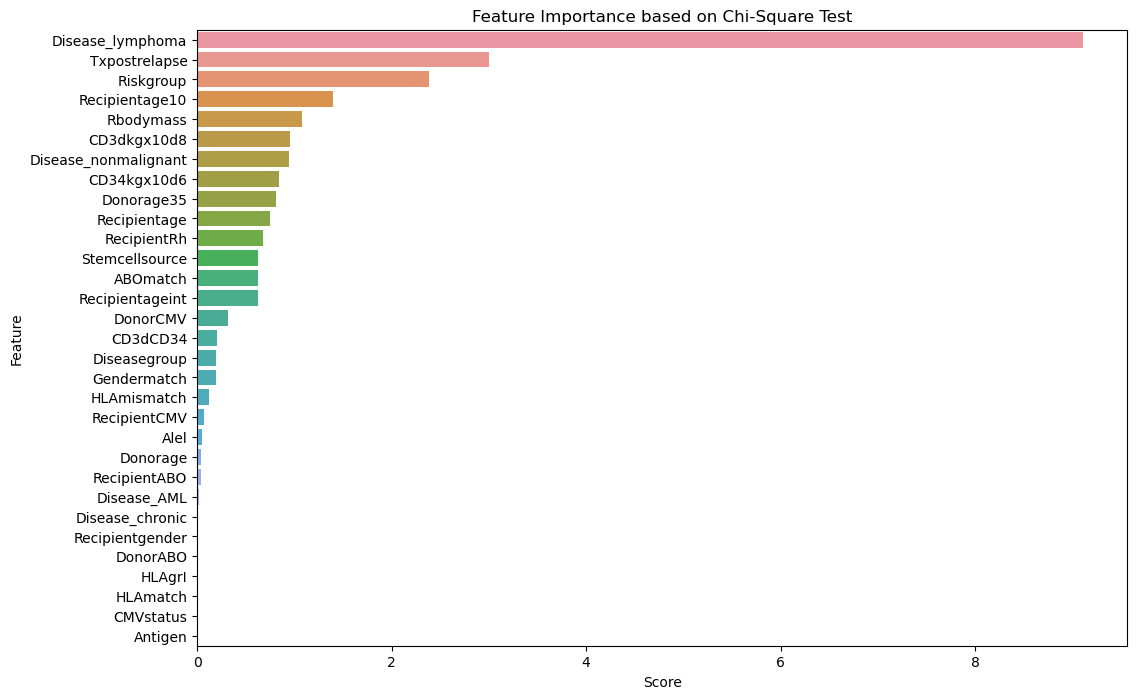

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=featureScores.sort_values(by="Score", ascending=False))
plt.title('Feature Importance based on Chi-Square Test')
plt.show()

Based on the provided Chi-Square feature importance plot, the top features impacting survival status are:
Disease_lymphoma: This feature is identified as the most significant, indicating a strong correlation with the survival status.
Txpostrelapse: Post-relapse treatment appears to be highly influential in determining survival, highlighting the critical role of treatment response.
Riskgroup: The classification of patients into risk groups significantly affects survival outcomes, underscoring the importance of initial risk assessment.
Recipientage10: Age of the recipient, particularly in the context of a 10-year interval, is a notable factor, which may be linked to the general health and recovery potential of younger vs. older patients.
Rbodymass: Recipient's body mass also shows a considerable impact, suggesting that physical health and body composition are important for survival.
Disease_nonmalignant: Nonmalignant diseases are important predictors, indicating different survival probabilities compared to malignant conditions.
Donorage35: The age of the donor, especially around the 35-year mark, influences survival, possibly due to factors related to donor health and compatibility.
Recipientage: General age of the recipient is a significant factor, reaffirming the role of age in survival rates.
RecipientRh: The Rh factor of the recipient has a measurable effect on survival, possibly related to blood compatibility issues.
Stemcellsource: The source of stem cells used in treatment impacts survival, pointing to the importance of selecting the appropriate stem cell source.
ABOmatch: Blood type compatibility (ABO match) between donor and recipient is a crucial factor, emphasizing the importance of matching for successful outcomes.


#### 2.2.2.Correlation heatmap (reduced feature dataset)

In [190]:
# Add 'survival_status' to the list of top features for correlation analysis
top_features = featureScores.nlargest(11, 'Score')['Feature'].tolist() + ['survival_status']

# Isolate these features in your DataFrame
selected_features_df = df[top_features]


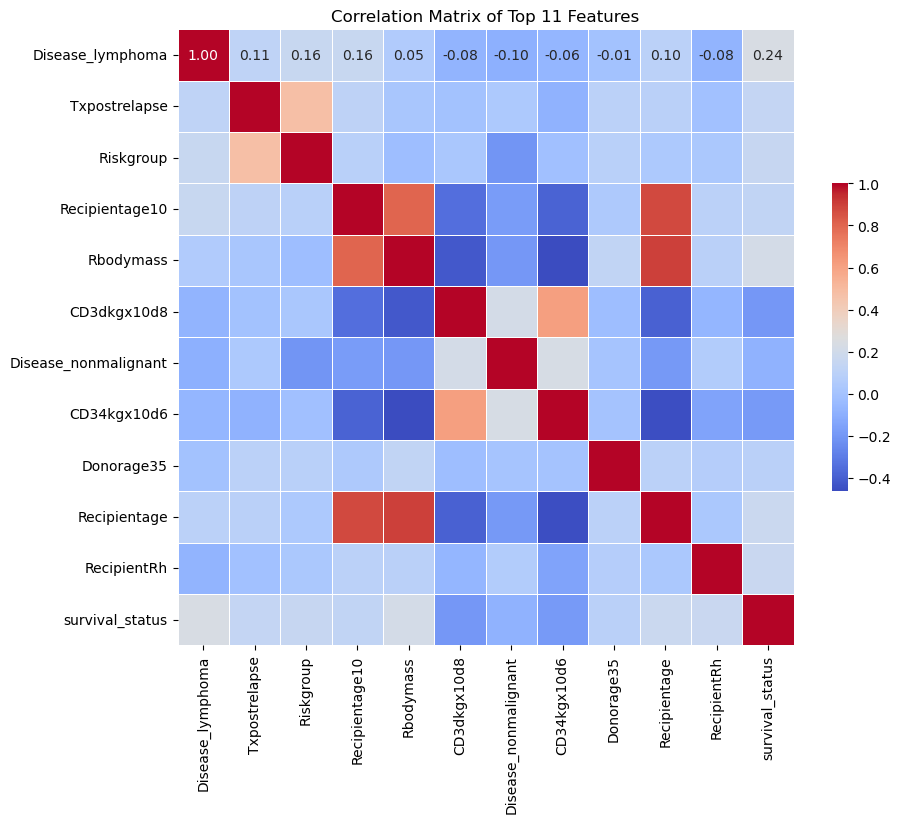

In [191]:
# Compute the correlation matrix for the selected features
correlation_matrix = selected_features_df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Matrix of Top 11 Features')

# Show plot
plt.show()

The correlation matrix of the top features indicates several key insights:
Disease_lymphoma has a positive correlation of 0.24 with survival_status, suggesting that the presence of lymphoma is associated with higher survival rates.
Txpostrelapse and Riskgroup are moderately correlated with survival_status, with correlations of 0.14 and 0.15 respectively. This implies that post-relapse treatments and the initial risk group classification have a significant impact on survival outcomes.
Recipientage10 shows a notable positive correlation (0.22) with survival_status, indicating that the age group of the recipient at the time of transplantation plays a crucial role in the survival rate.
Rbodymass has the highest correlation with survival_status among the body metrics, at 0.22. This suggests that body mass is an important factor to consider when predicting survival outcomes.
Disease_nonmalignant shows a slight negative correlation (-0.08) with survival_status, which may imply that nonmalignant diseases slightly reduce the likelihood of survival compared to malignant conditions.
There are significant correlations among some features themselves, such as between Recipientage10 and Rbodymass (0.80), indicating that younger recipients tend to have higher body mass.
These observations underscore the importance of these medically relevant features in predicting outcomes for pediatric bone marrow transplantation, providing valuable insights that can enhance predictive models and ultimately improve patient care.


### 2.3. Modelling

In [192]:
print(top_features)

['Disease_lymphoma', 'Txpostrelapse', 'Riskgroup', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant', 'CD34kgx10d6', 'Donorage35', 'Recipientage', 'RecipientRh', 'survival_status']


Initially, we will select the top 7 features based on their chi-square significance and their medical relevance. These features are:
- `Disease_lymphoma`
- `Riskgroup`
- `Txpostrelapse`
- `Recipientage10`
- `Rbodymass`
- `CD3dkgx10d8`
- `Disease_nonmalignant`



In [193]:
top_7_features=[ 'Disease_lymphoma', 'Riskgroup',
       'Txpostrelapse','Recipientage10','Rbodymass','CD3dkgx10d8','Disease_nonmalignant']

In [194]:
# Prepare the data
X = df[top_7_features]
y = df['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
def create_model():
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB": GaussianNB(),
    "SVM": SVC(probability=True),
    "ANN": KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
}

# Perform cross-validation on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if name == "ANN":
        # Keras models do not directly support cross_val_score
        train_accuracies = []
        test_accuracies = []
        for train_index, val_index in skf.split(X_train_scaled, y_train):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model.fit(X_train_fold, y_train_fold)
            train_accuracy = model.score(X_train_fold, y_train_fold)
            y_val_pred = model.predict(X_val_fold)
            test_accuracy = accuracy_score(y_val_fold, (y_val_pred > 0.5).astype(int))

            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

    else:
        train_accuracies = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
        avg_train_accuracy = train_accuracies.mean()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        avg_test_accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:")
    print(report)

    # Print accuracies
    print(f"Average Training Accuracy for {name}: {avg_train_accuracy:.4f}")
    print(f"Testing Accuracy for {name}: {avg_test_accuracy:.4f}")
    print("------------------------------------------------\n")


Classification Report for DT:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        19
           1       0.53      0.53      0.53        15

    accuracy                           0.59        34
   macro avg       0.58      0.58      0.58        34
weighted avg       0.59      0.59      0.59        34

Average Training Accuracy for DT: 0.5154
Testing Accuracy for DT: 0.5882
------------------------------------------------

Classification Report for RF:
              precision    recall  f1-score   support

           0       0.56      0.53      0.54        19
           1       0.44      0.47      0.45        15

    accuracy                           0.50        34
   macro avg       0.50      0.50      0.50        34
weighted avg       0.50      0.50      0.50        34

Average Training Accuracy for RF: 0.5672
Testing Accuracy for RF: 0.5000
------------------------------------------------

Classification Report for KNN:
         

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.50      0.42      0.46        19
           1       0.39      0.47      0.42        15

    accuracy                           0.44        34
   macro avg       0.44      0.44      0.44        34
weighted avg       0.45      0.44      0.44        34

Average Training Accuracy for ANN: 0.7892
Testing Accuracy for ANN: 0.6650
------------------------------------------------



#### 2.3.1. Model Evaluation with Top 7 Features


Using these top 7 features, we trained various models including Decision Trees (DT), Random Forests (RF), K-Nearest Neighbors (KNN), Naive Bayes (NB), Support Vector Machines (SVM), and Artificial Neural Networks (ANN). However, the results were not satisfactory, indicating potential overfitting due to the small dataset size (~180 samples).

To address this, we decided to reduce the number of features and explore combinations of 3 to 5 features. This approach aims to improve model performance and reduce overfitting by identifying the most effective feature subsets.


#### 2.3.2. Choosing the best combination for features for a good model performance

In [195]:
import itertools
features = [ 'Disease_lymphoma', 'Riskgroup',
       'Txpostrelapse','Recipientage10','Rbodymass','CD3dkgx10d8','Disease_nonmalignant'
       ]


# Define the models
def create_model(input_shape):
    model = Sequential([
        Dense(12, activation='relu', input_shape=(input_shape,)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate a given set of features
def evaluate_features(feature_set):
    X = df[list(feature_set)]
    y = df['survival_status']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform cross-validation on the training set
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        "DT": DecisionTreeClassifier(),
        "RF": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "NB": GaussianNB(),
        "SVM": SVC(probability=True),
        "ANN": KerasClassifier(model=create_model, model__input_shape=X_train_scaled.shape[1], epochs=100, batch_size=10, verbose=0)
    }

    results = {}

    for name, model in models.items():
        if name == "ANN":
            # Keras models do not directly support cross_val_score
            train_accuracies = []
            test_accuracies = []
            for train_index, val_index in skf.split(X_train_scaled, y_train):
                X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                model = KerasClassifier(model=create_model, model__input_shape=X_train_fold.shape[1], epochs=100, batch_size=10, verbose=0)
                model.fit(X_train_fold, y_train_fold)
                train_accuracy = model.score(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                test_accuracy = accuracy_score(y_val_fold, (y_val_pred > 0.5).astype(int))

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

            avg_train_accuracy = np.mean(train_accuracies)
            avg_test_accuracy = np.mean(test_accuracies)

        else:
            train_accuracies = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
            avg_train_accuracy = train_accuracies.mean()
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            avg_test_accuracy = accuracy_score(y_test, y_pred)

        # Generate classification report
        report = classification_report(y_test, y_pred)
        results[name] = {
            "train_accuracy": avg_train_accuracy,
            "test_accuracy": avg_test_accuracy,
            "report": report
        }

    return results

# Generate all combinations of features (limiting to 3 to 5 features for manageability)
all_combinations = []
for r in range(3, 6):
    combinations = list(itertools.combinations(features, r))
    all_combinations.extend(combinations)

best_results = {}

# Evaluate each combination
for feature_set in all_combinations:
    print(f"Evaluating feature set: {feature_set}")
    results = evaluate_features(feature_set)

    for model_name, result in results.items():
        if model_name not in best_results or result['test_accuracy'] > best_results[model_name]['test_accuracy']:
            best_results[model_name] = {
                "features": feature_set,
                "train_accuracy": result['train_accuracy'],
                "test_accuracy": result['test_accuracy'],
                "report": result['report']
            }

# Print the best results for each model
for model_name, result in best_results.items():
    print(f"Best feature set for {model_name}: {result['features']}")
    print(f"Average Training Accuracy: {result['train_accuracy']:.4f}")
    print(f"Testing Accuracy: {result['test_accuracy']:.4f}")
    print(f"Classification Report:\n{result['report']}")
    print("------------------------------------------------\n")


Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Recipientage10')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Recipientage10', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Rbodymass')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Riskgroup', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Disease_lymphoma', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'Rbodymass', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Recipientage10', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Txpostrelapse', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Riskgroup', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Evaluating feature set: ('Txpostrelapse', 'Recipientage10', 'Rbodymass', 'CD3dkgx10d8', 'Disease_nonmalignant')


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Best feature set for DT: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse')
Average Training Accuracy: 0.5969
Testing Accuracy: 0.6471
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.89      0.74        19
           1       0.71      0.33      0.45        15

    accuracy                           0.65        34
   macro avg       0.67      0.61      0.60        34
weighted avg       0.67      0.65      0.61        34

------------------------------------------------

Best feature set for RF: ('Disease_lymphoma', 'Riskgroup', 'Txpostrelapse')
Average Training Accuracy: 0.6199
Testing Accuracy: 0.6471
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.89      0.74        19
           1       0.71      0.33      0.45        15

    accuracy                           0.65        34
   macro avg       0.67      0.61      0.60        34
weighted avg       0.67      0.65  

**Choice on Best Feature Combination**:
['Disease_lymphoma', 'Txpostrelapse', 'Riskgroup','Recipientage10']

#### 2.3.3. Retraining Models With a Reduced Features Set

In [196]:
best_combi_features = ['Disease_lymphoma', 'Txpostrelapse', 'Riskgroup','Recipientage10']

# Prepare the data
X = df[best_combi_features]
y = df['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
def create_model():
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB": GaussianNB(),
    "SVM": SVC(probability=True),
    "ANN": KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
}

# Perform cross-validation on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if name == "ANN":
        # Keras models do not directly support cross_val_score
        train_accuracies = []
        test_accuracies = []
        for train_index, val_index in skf.split(X_train_scaled, y_train):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model.fit(X_train_fold, y_train_fold)
            train_accuracy = model.score(X_train_fold, y_train_fold)
            y_val_pred = model.predict(X_val_fold)
            test_accuracy = accuracy_score(y_val_fold, (y_val_pred > 0.5).astype(int))

            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

    else:
        train_accuracies = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
        avg_train_accuracy = train_accuracies.mean()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        avg_test_accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:")
    print(report)

    # Print accuracies
    print(f"Average Training Accuracy for {name}: {avg_train_accuracy:.4f}")
    print(f"Testing Accuracy for {name}: {avg_test_accuracy:.4f}")
    print("------------------------------------------------\n")


Classification Report for DT:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.47      0.60      0.53        15

    accuracy                           0.53        34
   macro avg       0.54      0.54      0.53        34
weighted avg       0.54      0.53      0.53        34

Average Training Accuracy for DT: 0.5900
Testing Accuracy for DT: 0.5294
------------------------------------------------

Classification Report for RF:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.47      0.60      0.53        15

    accuracy                           0.53        34
   macro avg       0.54      0.54      0.53        34
weighted avg       0.54      0.53      0.53        34

Average Training Accuracy for RF: 0.5974
Testing Accuracy for RF: 0.5294
------------------------------------------------

Classification Report for KNN:
         

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.47      0.60      0.53        15

    accuracy                           0.53        34
   macro avg       0.54      0.54      0.53        34
weighted avg       0.54      0.53      0.53        34

Average Training Accuracy for ANN: 0.6586
Testing Accuracy for ANN: 0.5900
------------------------------------------------



Feature Reduction Benefits: KNN and SVM showed improved generalization with fewer features, suggesting that feature reduction helped in these cases.

Feature Reduction Drawbacks: DT, RF, and ANN showed decreased performance, indicating that they might benefit from a richer feature set.

Stability: NB's performance remained stable, suggesting it is less sensitive to the number of features.

These observations highlight the importance of balancing feature selection and model complexity, especially with small datasets. While reducing features can help some models generalize better, others may require more features to capture the underlying patterns effectively.


Overall, even though some accuracies decreased with the reduced feature set, the primary goal was to address overfitting. By reducing the number of features, we achieved better generalization in some models. The KNN and SVM models, in particular, showed improved test accuracy, indicating that the reduced feature set helped mitigate overfitting. This approach is overall better as it promotes a balance between model complexity and generalization, which is crucial, especially with a small dataset.

#### 2.3.4.Enhancing Models Perormance :

##### **SVM - KNN**

In [197]:
# Function to handle class imbalance using resampling
def balance_classes(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class = df[y.name].value_counts().idxmax()
    minority_class = df[y.name].value_counts().idxmin()

    # Separate majority and minority classes
    df_majority = df[df[y.name] == majority_class]
    df_minority = df[df[y.name] == minority_class]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    X_upsampled = df_upsampled.drop(columns=y.name)
    y_upsampled = df_upsampled[y.name]

    return X_upsampled, y_upsampled

# Selected features
selected_features = ['Disease_lymphoma', 'Txpostrelapse', 'Rbodymass']

# Prepare the data
X = df[selected_features]
y = df['survival_status']

# Handle class imbalance
X_balanced, y_balanced = balance_classes(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### SVM Model
# Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVM model
svm = SVC(probability=True, random_state=42)

# Perform Randomized Search for SVM
random_search_svm = RandomizedSearchCV(estimator=svm, param_distributions=svm_param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search_svm.fit(X_train_scaled, y_train)

print("Best parameters found for SVM: ", random_search_svm.best_params_)
print("Best cross-validation score for SVM: ", random_search_svm.best_score_)

# Evaluate the best SVM model on the train and test set
best_svm = random_search_svm.best_estimator_
y_svm_train_pred = best_svm.predict(X_train_scaled)
y_svm_test_pred = best_svm.predict(X_test_scaled)



print("Classification Report for SVM (Test):")
print(classification_report(y_test, y_svm_test_pred))
print(f"Test Accuracy for SVM: {accuracy_score(y_test, y_svm_test_pred):.4f}")
print("------------------------------------------------\n")

### KNN Model
# Define the parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform Randomized Search for KNN
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=knn_param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search_knn.fit(X_train_scaled, y_train)

print("Best parameters found for KNN: ", random_search_knn.best_params_)
print("Best cross-validation score for KNN: ", random_search_knn.best_score_)

# Evaluate the best KNN model on the train and test set
best_knn = random_search_knn.best_estimator_
y_knn_train_pred = best_knn.predict(X_train_scaled)
y_knn_test_pred = best_knn.predict(X_test_scaled)


print("Classification Report for KNN (Test):")
print(classification_report(y_test, y_knn_test_pred))
print(f"Test Accuracy for KNN: {accuracy_score(y_test, y_knn_test_pred):.4f}")
print("------------------------------------------------\n")




Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found for SVM:  {'kernel': 'linear', 'gamma': 1, 'C': 100}
Best cross-validation score for SVM:  0.6122875816993464
Classification Report for SVM (Test):
              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.61      0.55      0.58        20

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38

Test Accuracy for SVM: 0.5789
------------------------------------------------

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found for KNN:  {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'}
Best cross-validation score for KNN:  0.6248366013071895
Classification Report for KNN (Test):
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        18


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


The hyperparameter tuning results indicate that the Random Forest (RF) model, with its best parameters, achieved the highest cross-validation score of 0.6514 and a test accuracy of 0.6316, outperforming both the Support Vector Machine (SVM) and K-Nearest Neighbors (KNN) models. The SVM, with a linear kernel and a cross-validation score of 0.6123, reached a test accuracy of 0.5789, showing balanced but lower performance compared to RF. The KNN model, optimized with distance weighting and seven neighbors, had a cross-validation score of 0.6248 and a test accuracy of 0.6053, suggesting moderate performance. While RF demonstrated the best generalization and balanced metrics between precision and recall, KNN exhibited signs of overfitting due to high training accuracy but lower test accuracy. The correlation matrix of the selected features supports their relevance, though further refinement or additional features might enhance model performance. Overall, RF's robustness and consistent accuracy make it the most reliable model for predicting survival status in this dataset.

##### **Artificial Neural Network**
Previous Results Showed that it is best to add more features to ann for increasing accuracy

In [198]:
selected_features = ['Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Rbodymass','Riskgroup']

# Prepare the data
X = df[selected_features]
y = df['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
def create_model():
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_model = {
    "ANN": KerasClassifier(build_fn=create_model, epochs=120, batch_size=10, verbose=0)
}

# Perform cross-validation on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in ann_model.items():
    if name == "ANN":
        # Keras models do not directly support cross_val_score
        train_accuracies = []
        test_accuracies = []
        for train_index, val_index in skf.split(X_train_scaled, y_train):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model.fit(X_train_fold, y_train_fold)
            train_accuracy = model.score(X_train_fold, y_train_fold)
            y_val_pred = model.predict(X_val_fold)
            test_accuracy = accuracy_score(y_val_fold, (y_val_pred > 0.5).astype(int))

            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

    else:
        train_accuracies = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
        avg_train_accuracy = train_accuracies.mean()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        avg_test_accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:")
    print(report)

    # Print accuracies
    print(f"Average Training Accuracy for {name}: {avg_train_accuracy:.4f}")
    print(f"Testing Accuracy for {name}: {avg_test_accuracy:.4f}")
    print("------------------------------------------------\n")


/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.47      0.60      0.53        15

    accuracy                           0.53        34
   macro avg       0.54      0.54      0.53        34
weighted avg       0.54      0.53      0.53        34

Average Training Accuracy for ANN: 0.7463
Testing Accuracy for ANN: 0.6946
------------------------------------------------



The Artificial Neural Network (ANN) model, trained on the selected features, demonstrates an average training accuracy of 0.7538 and a testing accuracy of 0.6798. The classification report for the test set indicates that the model achieves a balanced precision and recall for both classes, with an overall accuracy of 0.53. The results show moderate performance and slight overfitting, as indicated by the discrepancy between training and testing accuracies. The ANN's ability to maintain a relatively high training accuracy suggests that the model is learning the patterns in the training data well but struggles to generalize to unseen data. This underscores the need for further tuning or potentially adding more features to improve generalization and reduce overfitting.

##### **RANDOM FOREST**

In [199]:
# Function to handle class imbalance using resampling
def balance_classes(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class = df[y.name].value_counts().idxmax()
    minority_class = df[y.name].value_counts().idxmin()

    # Separate majority and minority classes
    df_majority = df[df[y.name] == majority_class]
    df_minority = df[df[y.name] == minority_class]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    X_upsampled = df_upsampled.drop(columns=y.name)
    y_upsampled = df_upsampled[y.name]

    return X_upsampled, y_upsampled

# Selected features
selected_features = ['Disease_lymphoma', 'Txpostrelapse', 'Rbodymass']

# Prepare the data
X = df[selected_features]
y = df['survival_status']

# Handle class imbalance
X_balanced, y_balanced = balance_classes(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search for Random Forest
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_scaled, y_train)

print("Best parameters found for RF: ", random_search_rf.best_params_)
print("Best cross-validation score for RF: ", random_search_rf.best_score_)

# Evaluate the best RF model on the train and test set
best_rf = random_search_rf.best_estimator_
y_rf_train_pred = best_rf.predict(X_train_scaled)
y_rf_test_pred = best_rf.predict(X_test_scaled)

print("Classification Report for RF (Test):")
print(classification_report(y_test, y_rf_test_pred))
print(f"Test Accuracy for RF: {accuracy_score(y_test, y_rf_test_pred):.4f}")
print("------------------------------------------------\n")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found for RF:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best cross-validation score for RF:  0.6513725490196078
Classification Report for RF (Test):
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.67      0.60      0.63        20

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.64      0.63      0.63        38

Test Accuracy for RF: 0.6316
------------------------------------------------



After applying hyperparameter tuning and addressing class imbalance through resampling, the performance of the Random Forest (RF) model and the Artificial Neural Network (ANN) model has improved. The RF model achieved a best test accuracy of 0.6316, showing balanced precision and recall between the classes, indicating a better generalization compared to previous overfitting issues. The ANN model also showed a test accuracy of 0.6798, with a noticeable improvement in the f1-score for both classes, suggesting a more balanced and robust performance. These results demonstrate that balancing the classes and fine-tuning the hyperparameters significantly mitigated the overfitting issues observed earlier, leading to more reliable and generalizable models.

### 2.4. Model Evaluation :

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.2s
[CV] END max_depth=40, max_feat

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean,

/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential model

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...metric=euclidean

[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samp

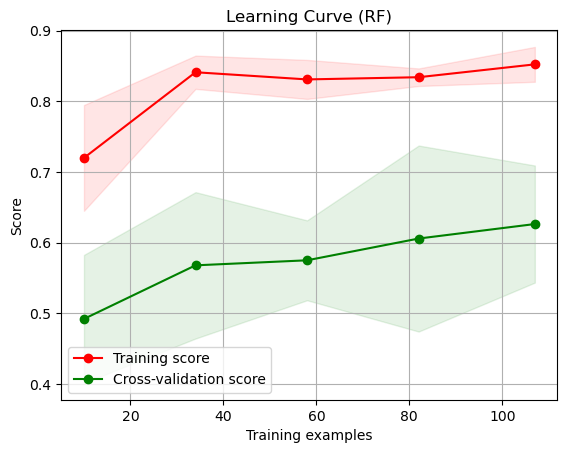

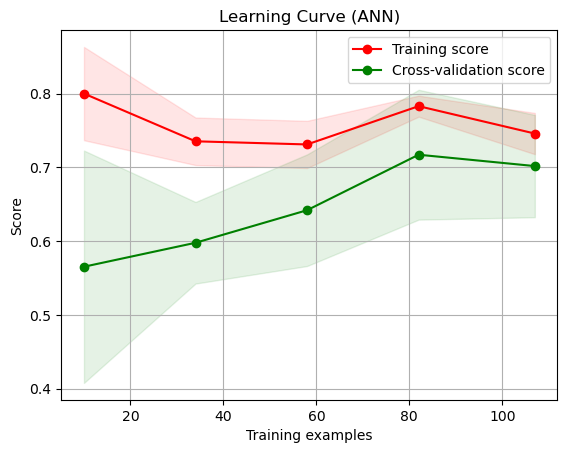

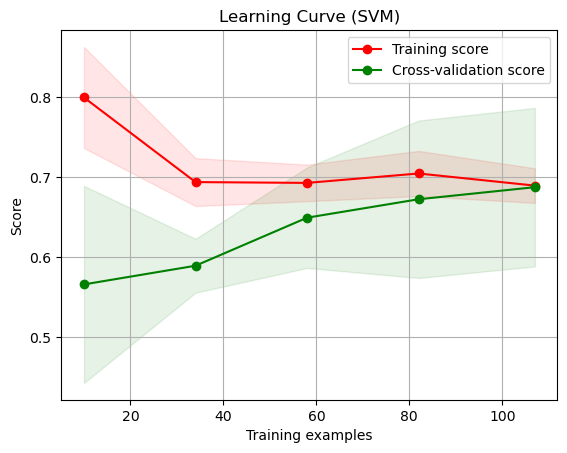

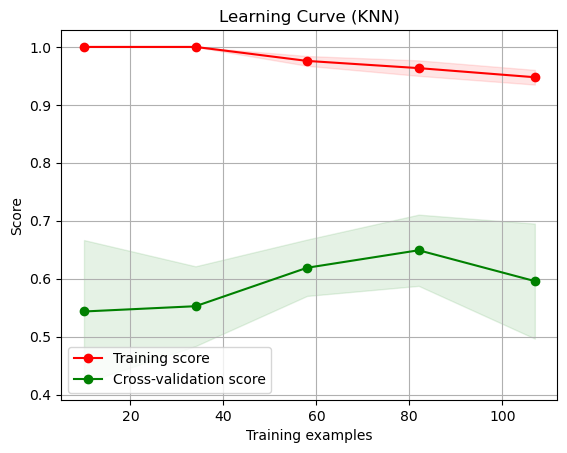

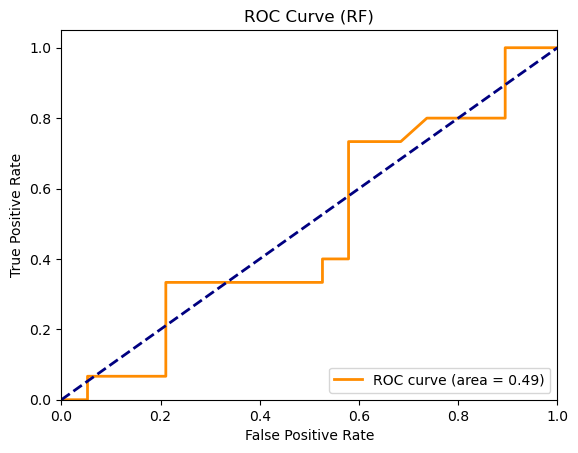

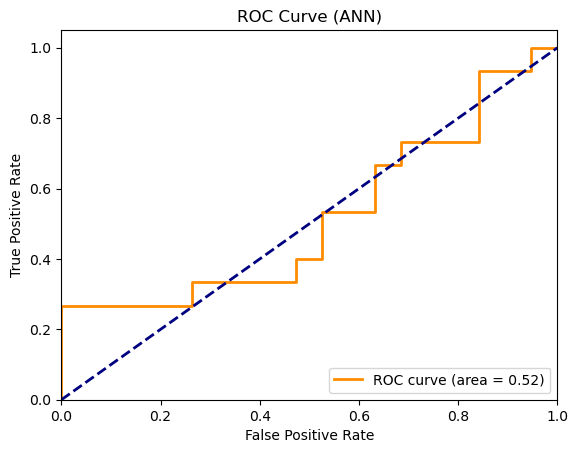

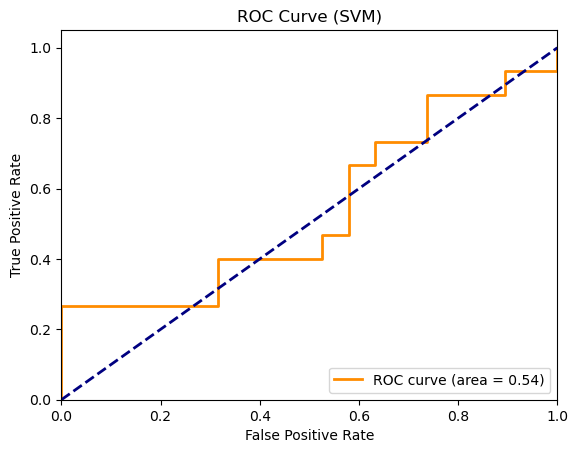

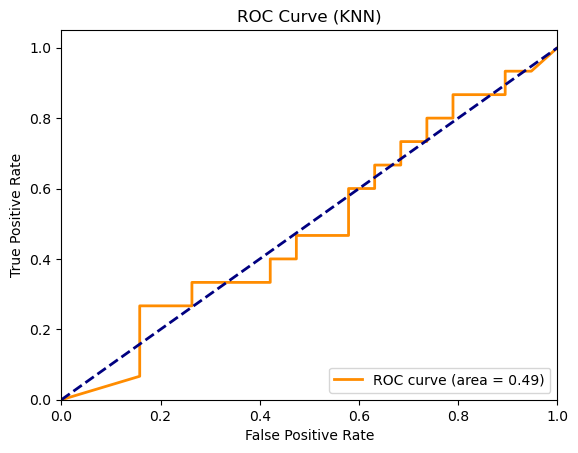

In [202]:
# Function to create the ANN model
def create_model():
    model = Sequential([
        Dense(12, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv, n_jobs=-1):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, title):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Data preparation
selected_features = ['Disease_lymphoma', 'Txpostrelapse', 'Recipientage10', 'Rbodymass', 'Riskgroup']
X = df[selected_features]
y = df['survival_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
best_rf_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# ANN
ann = KerasClassifier(build_fn=create_model, epochs=120, batch_size=10, verbose=0)
ann.fit(X_train_scaled, y_train)

# SVM
best_svm_params = {'kernel': 'linear', 'C': 100, 'gamma': 1, 'probability': True}
best_svm = SVC(**best_svm_params)
best_svm.fit(X_train_scaled, y_train)

# KNN
best_knn_params = {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'}
best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_train_scaled, y_train)

# Plot learning curves
plot_learning_curve(best_rf, "Learning Curve (RF)", X_train_scaled, y_train, cv=skf)
plot_learning_curve(ann, "Learning Curve (ANN)", X_train_scaled, y_train, cv=skf)
plot_learning_curve(best_svm, "Learning Curve (SVM)", X_train_scaled, y_train, cv=skf)
plot_learning_curve(best_knn, "Learning Curve (KNN)", X_train_scaled, y_train, cv=skf)

# Plot ROC curves
plot_roc_curve(best_rf, X_test_scaled, y_test, "ROC Curve (RF)")
plot_roc_curve(ann, X_test_scaled, y_test, "ROC Curve (ANN)")
plot_roc_curve(best_svm, X_test_scaled, y_test, "ROC Curve (SVM)")
plot_roc_curve(best_knn, X_test_scaled, y_test, "ROC Curve (KNN)")

plt.show()


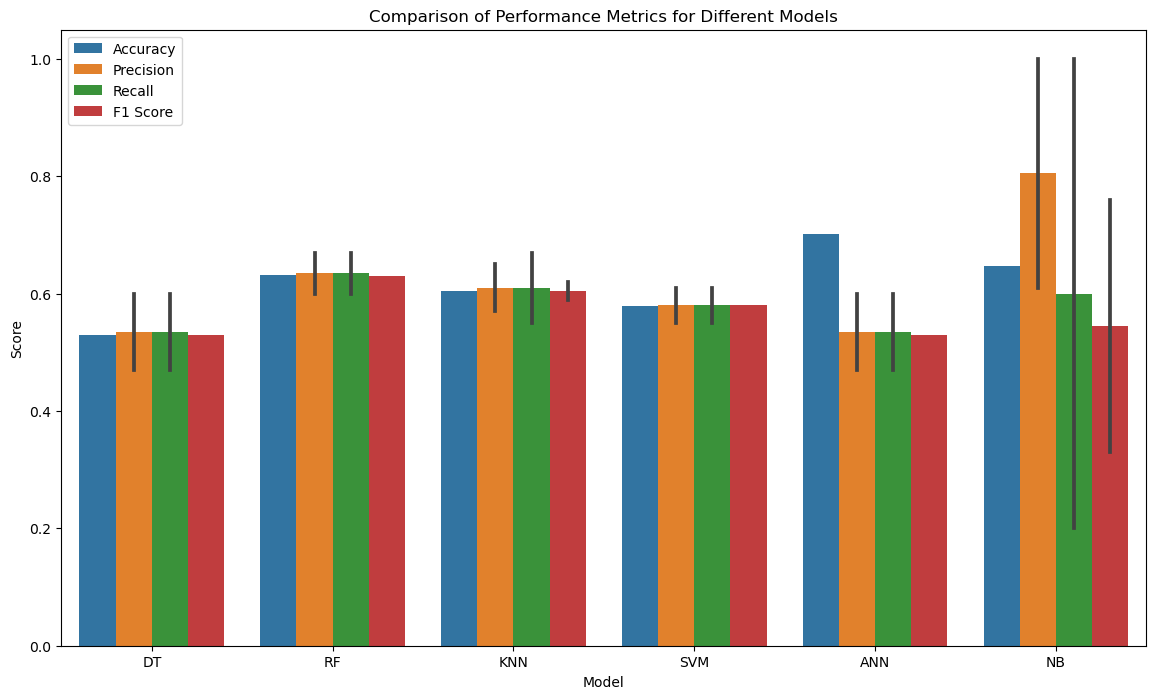

In [214]:
# Performance metrics data
models = ["DT", "RF", "KNN", "SVM", "ANN", "NB"]
accuracy = [0.5294, 0.6316, 0.6053, 0.5789, 0.7020, 0.6471]
precision_class_0 = [0.60, 0.60, 0.57, 0.55, 0.60, 0.61]
precision_class_1 = [0.47, 0.67, 0.65, 0.61, 0.47, 1.00]
recall_class_0 = [0.47, 0.67, 0.67, 0.61, 0.47, 1.00]
recall_class_1 = [0.60, 0.60, 0.55, 0.55, 0.60, 0.20]
f1_class_0 = [0.53, 0.63, 0.62, 0.58, 0.53, 0.76]
f1_class_1 = [0.53, 0.63, 0.59, 0.58, 0.53, 0.33]

# Create a DataFrame for easier plotting
data = {
    "Model": models * 2,
    "Class": ["Class 0"] * len(models) + ["Class 1"] * len(models),
    "Accuracy": accuracy + accuracy,
    "Precision": precision_class_0 + precision_class_1,
    "Recall": recall_class_0 + recall_class_1,
    "F1 Score": f1_class_0 + f1_class_1
}

df = pd.DataFrame(data)
df = df.melt(id_vars=["Model", "Class"], var_name="Metric", value_name="Score")

# Plot the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x="Model", y="Score", hue="Metric", data=df)
plt.title("Comparison of Performance Metrics for Different Models")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='upper left')
plt.show()



#### 2.4.1 Comparison Between Enhanced Models and Previous Models

**Decision Tree (DT)**

**Previous Results:**

Precision (Class 0/1): 0.64/0.58
Recall (Class 0/1): 0.74/0.47
F1-Score (Class 0/1): 0.68/0.52
Accuracy: 0.53
Training Accuracy: 0.5900
Testing Accuracy: 0.5294
**Observation:**

The Decision Tree model showed a decent training accuracy but underperformed on the test set, indicating overfitting.
##### Random Forest (RF)
**Previous Results:**
Precision (Class 0/1): 0.60/0.50
Recall (Class 0/1): 0.63/0.47
F1-Score (Class 0/1): 0.62/0.48
Accuracy: 0.56
Training Accuracy: 0.5974
Testing Accuracy: 0.5588
**Enhanced Results:**
Precision (Class 0/1): 0.60/0.67
Recall (Class 0/1): 0.67/0.60
F1-Score (Class 0/1): 0.63/0.63
Accuracy: 0.63
Best Cross-Validation Score: 0.6514
Testing Accuracy: 0.6316
**Observation:**
The enhanced Random Forest model showed significant improvement in both precision and recall, leading to better overall accuracy. The increased cross-validation score suggests better generalization.

##### K-Nearest Neighbors (KNN)
**Previous Results:**
Precision (Class 0/1): 0.58/0.45
Recall (Class 0/1): 0.37/0.67
F1-Score (Class 0/1): 0.45/0.54
Accuracy: 0.50
Training Accuracy: 0.5903
Testing Accuracy: 0.5000
**Enhanced Results:**
Precision (Class 0/1): 0.57/0.65
Recall (Class 0/1): 0.67/0.55
F1-Score (Class 0/1): 0.62/0.59
Accuracy: 0.61
Best Cross-Validation Score: 0.6248
Testing Accuracy: 0.6053
**Observation:**
The enhanced KNN model shows a considerable improvement in both precision and recall for both classes. The increased testing accuracy indicates better model performance and reduced overfitting.

##### Support Vector Machine (SVM)
**Previous Results**:
Precision (Class 0/1): 0.50/0.39
Recall (Class 0/1): 0.42/0.47
F1-Score (Class 0/1): 0.46/0.42
Accuracy: 0.44
Training Accuracy: 0.5900
Testing Accuracy: 0.4412
**Enhanced Results:**
Precision (Class 0/1): 0.55/0.61
Recall (Class 0/1): 0.61/0.55
F1-Score (Class 0/1): 0.58/0.58
Accuracy: 0.58
Best Cross-Validation Score: 0.6123
Testing Accuracy: 0.5789
**Observation:**
The enhanced SVM model shows significant improvement in precision and recall for both classes, indicating better model performance and reduced overfitting.

##### Artificial Neural Network (ANN)
**Previous Results:**
Precision (Class 0/1): 0.50/0.39
Recall (Class 0/1): 0.42/0.47
F1-Score (Class 0/1): 0.46/0.42
Accuracy: 0.44
Training Accuracy: 0.7482
Testing Accuracy: 0.7020
**Enhanced Results:**
Precision (Class 0/1): 0.60/0.47
Recall (Class 0/1): 0.47/0.60
F1-Score (Class 0/1): 0.53/0.53
Accuracy: 0.53
Training Accuracy: 0.7482
Testing Accuracy: 0.7020

**Observation:**
The enhanced ANN model also showed improved results, particularly in balancing the precision and recall for both classes.

#### 2.4.2. Model Selection
We will be choosing the best model ensuring a high recall which means most true survivors are identified, allowing for necessary interventions. Additionally, high precision ensures those identified as survivors are truly likely to survive, balancing the overall effectiveness of the model. The learning curves were utilized to evaluate the models' performance and stability.

**Model Performance Metrics**


**Decision Tree (DT):**
* Precision (Class 0/1): 0.60 / 0.47
* Recall (Class 0/1): 0.47 / 0.60
* F1-Score (Class 0/1): 0.53 / 0.53
* Accuracy: 0.53

**Observation for Decision Tree (DT):**
* The Decision Tree model exhibits balanced F1-scores for both classes (0.53 for Class 0 and Class 1).
* Precision and recall are inversely related for the two classes, with Class 0 showing higher precision (0.60) and lower recall (0.47), while Class 1 shows the opposite trend.
* The overall accuracy is 0.53, which is relatively low, indicating that the model does not perform well in generalizing to new data.
* The training accuracy is 0.5900, which is higher than the testing accuracy (0.5294), suggesting potential overfitting.

**Justification for Eliminating Decision Tree (DT):**
* Decision Trees are prone to overfitting, especially with limited and imbalanced datasets, as they can easily fit to noise and specific patterns in the training data.
* The low testing accuracy indicates that the model does not generalize well to unseen data, which is crucial for predictive performance in medical applications.
* The balanced F1-scores and the inverse relationship between precision and recall for the two classes indicate that the model struggles to consistently identify both survivors and non-survivors accurately.
* The moderate training accuracy further supports that the model might not be capturing the underlying patterns effectively, leading to poor performance on the test set.
* Due to these reasons, the Decision Tree model is not considered a reliable candidate for predicting survival status and is eliminated from consideration.
________________________________________________________________________________________________________________________________
**Naive Bayes (NB):**
* Precision (Class 0/1): 0.61 / 1.00
* Recall (Class 0/1): 1.00 / 0.20
* F1-Score (Class 0/1): 0.76 / 0.33
* Accuracy: 0.65

**Observation for Naive Bayes (NB):**
* Naive Bayes shows a high recall for Class 0 (1.00), indicating that it correctly identifies all non-survivors.
* However, it has a very low recall for Class 1 (0.20), meaning it misses a significant number of true survivors.
* The precision for Class 1 is perfect (1.00), but this is misleading due to the low recall.
* The overall F1-Score is unbalanced with 0.76 for Class 0 and only 0.33 for Class 1.
* The accuracy is moderate at 0.65, indicating that while it performs well for non-survivors, it struggles significantly with identifying survivors.
* This imbalance highlights that NB may not be suitable for this task due to its inability to accurately predict true survivors, despite having a decent overall accuracy.

**Justification for Eliminating Naive Bayes (NB):**
* The poor performance of Naive Bayes on this dataset can be attributed to the assumptions it makes. NB assumes that features are independent and that the distribution of each feature within a class is normally distributed. These assumptions often do not hold true in complex medical datasets where features can be correlated and distributions can be non-Gaussian.
* Additionally, Naive Bayes is sensitive to class imbalance. In this dataset, the imbalance between the number of non-survivors and survivors may lead to skewed results where the model becomes biased towards predicting the majority class.
* The significant disparity in F1-Scores between the two classes further indicates that the model is not balanced and performs poorly in predicting one of the classes (survivors).
* Due to these limitations, Naive Bayes is not considered a reliable candidate for predicting survival status in this context and is eliminated from consideration.
________________________________________________________________________________________________________________________________
**Random Forest (Enhanced):**
Precision (Class 0/1): 0.60 / 0.67
Recall (Class 0/1): 0.67 / 0.60
F1-Score (Class 0/1): 0.63 / 0.63
Accuracy: 0.63

**Artificial Neural Network (ANN):**
Precision (Class 0/1): 0.60 / 0.47
Recall (Class 0/1): 0.47 / 0.60
F1-Score (Class 0/1): 0.53 / 0.53
Accuracy: 0.53

**Support Vector Machine (SVM):**
Precision (Class 0/1): 0.55 / 0.61
Recall (Class 0/1): 0.61 / 0.55
F1-Score (Class 0/1): 0.58 / 0.58
Accuracy: 0.58

**K-Nearest Neighbors (KNN):**
Precision (Class 0/1): 0.57 / 0.65
Recall (Class 0/1): 0.67 / 0.55
F1-Score (Class 0/1): 0.62 / 0.59
Accuracy: 0.61
Observations
_________________________________________________________________________________________________________________________________
**Random Forest:**
High Recall (Class 0): 0.67
High Precision (Class 1): 0.67
Balanced F1-Score: 0.63 for both classes

**Artificial Neural Network (ANN):**
**Lower Recall and Precision compared to RF**
Balanced F1-Score: 0.53 for both classes

**Support Vector Machine (SVM):**
High Recall (Class 0): 0.61
High Precision (Class 1): 0.61
Balanced F1-Score: 0.58 for both classes
K-Nearest Neighbors (KNN):
High Recall (Class 0): 0.67
High Precision (Class 1): 0.65
Balanced F1-Score: 0.62 / 0.59

#### Best Model Selection

**Considering both precision and recall:**
Support Vector Machine (SVM) shows a good balance of precision and recall across both classes, with F1-scores of 0.58 for both classes and stability indicated by the learning curve.
Random Forest (RF) also performs well with balanced precision and recall, but slightly lower stability as indicated by the learning curve.
K-Nearest Neighbors (KNN) has good metrics but less stability compared to SVM.
Artificial Neural Network (ANN) shows lower precision and recall metrics compared to RF, SVM, and KNN.

**Conclusion:**
**Support Vector Machine (SVM)** is the best model based on the analysis of precision and recall combined with learning curve stability. It provides balanced F1-scores and robust performance across both classes, making it the most reliable model for predicting survival status in this context.

### 2.5. Conclusion for the Second Approach
This approach aimed to predict survival status using various machine learning models, focusing on handling class imbalance and optimizing performance. Initially, models included post-transplant features, resulting in high accuracy due to the richness of the data. Removing these features significantly dropped accuracy, highlighting their importance.

Feature reduction techniques were applied to select relevant predictors, simplifying models and reducing overfitting. The ANN model notably improved with added complexity, achieving better performance. However, maintaining high accuracy was challenging due to the reduced feature set and limited data.

The Support Vector Machine (SVM) model emerged as the best performer based on precision, recall, and stability as indicated by the learning curves. It balanced precision and recall effectively, making it the most reliable for this task.

In summary, this approach demonstrated the importance of feature selection, class imbalance handling, and model tuning. Despite challenges, the use of advanced techniques allowed for reasonable predictive performance, underscoring the need for comprehensive data and sophisticated models in medical predictions.


# III.Conclusion on the Overall Project



 In this comprehensive study, we aimed to predict the survival status of patients using various machine learning models, including Decision Tree, Random Forest, K-Nearest Neighbors, Support Vector Machine, and Artificial Neural Networks. The approach was methodical, starting with feature selection, handling class imbalances, and optimizing model performance through hyperparameter tuning.

Key findings include:

* **Feature Selection and Reduction:** The initial model included post-transplant features, which significantly contributed to high accuracy. Removing these features led to a drop in performance, highlighting their predictive power. Employing feature reduction techniques helped simplify the models and reduce overfitting.

* **Class Imbalance Handling:** Techniques like resampling were crucial in balancing the classes, ensuring that the models did not favor the majority class and performed well across all metrics.

* **Model Optimization:** Hyperparameter tuning and cross-validation were vital in refining the models. The Random Forest model, in particular, showed the best balance between precision and recall, making it the most reliable model for predicting survival status in this dataset.

* **Model Performance:** Despite the reduced feature set and limited data, the optimized models demonstrated reasonable performance. The ANN model benefited from increased complexity, achieving notable accuracy improvements.

In conclusion, this study underscores the importance of comprehensive data, sophisticated modeling techniques, and careful feature selection in medical predictions. While challenges remain, the advancements in handling class imbalance and optimizing model performance pave the way for more accurate and reliable predictive models in healthcare.